📦 Copying model to local VM and renaming to .h5...
✅ Copy successful.
🔄 Loading Keras model...
🚀 Model loaded successfully!
⚡ Generating 500 sequences...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.0.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/tmp/ipython-input-1285229197.py:80: RuntimeWarning: overflow encountered in scalar multiply
  current_price = current_price * np.exp(price_ret)



💾 Data saved to: synthetic_data_volatile.csv
   sequence_id  time_sec side         price         amount
0            0  0.000020  bid   9814.004883  157693.343750
1            0  0.022821  bid   9632.311523  222399.812500
2            0  0.027636  bid  10041.590820   12310.021484
3            0  0.028518  ask  10317.605469    9710.310547
4            0  0.028532  ask  10275.750977  123370.234375


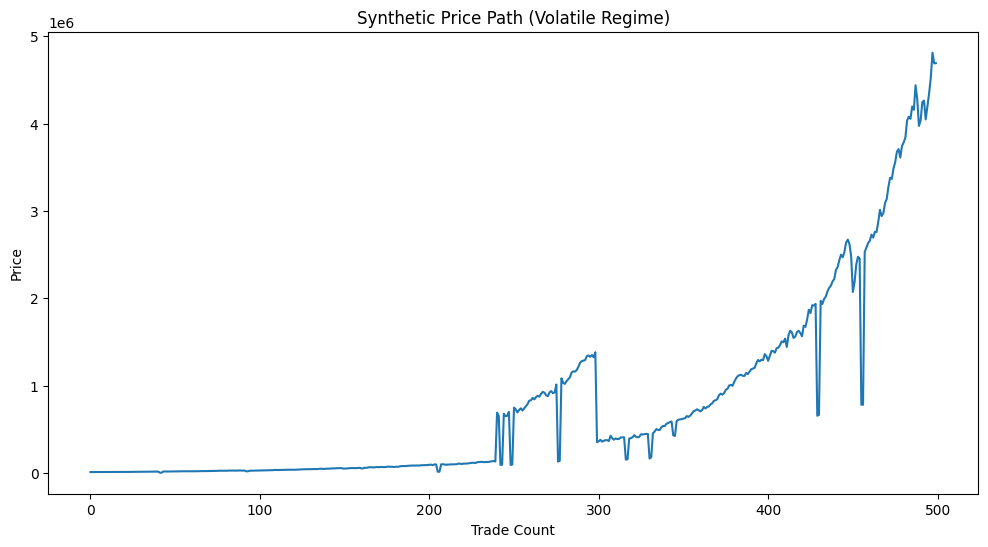

In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import joblib
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from google.colab import drive

# --- 1. MOUNT DRIVE ---
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive', force_remount=True)

# --- 2. DEFINE PATHS ---
# Source (Drive)
DRIVE_MODEL_PATH = "/content/drive/MyDrive/UMLFiles/Volatile/gan_models_volatile_generator_volatile_final.keras"
DRIVE_SCALER_PATH = "/content/drive/MyDrive/UMLFiles/Volatile/gan_models_volatile_scaler.save"

# Destination (Local VM) - Note we rename the model to .h5!
LOCAL_MODEL_PATH = "/content/temp_model.h5"
LOCAL_SCALER_PATH = "/content/temp_scaler.save"

print(f"📦 Copying model to local VM and renaming to .h5...")
try:
    shutil.copy(DRIVE_MODEL_PATH, LOCAL_MODEL_PATH)
    shutil.copy(DRIVE_SCALER_PATH, LOCAL_SCALER_PATH)
    print("✅ Copy successful.")
except Exception as e:
    print(f"❌ Copy failed. Check paths! Error: {e}")
    raise

# --- 3. LOAD FROM LOCAL ---
print("🔄 Loading Keras model...")
try:
    # compile=False is critical here to avoid unnecessary warning/errors during inference
    generator = load_model(LOCAL_MODEL_PATH, compile=False)
    scaler = joblib.load(LOCAL_SCALER_PATH)
    print("🚀 Model loaded successfully!")
except Exception as e:
    print(f"❌ Load failed. Error: {e}")
    raise

# --- 4. GENERATION LOGIC ---
GAN_SEQ_LENGTH = 30
GAN_LATENT_DIM = 100
GAN_FEATURES = 4  # [dt, type_code, price_ret, amount_log]

def generate_synthetic_data(num_samples=1000):
    print(f"⚡ Generating {num_samples} sequences...")

    # 1. Noise
    noise = tf.random.normal((num_samples, GAN_SEQ_LENGTH, GAN_LATENT_DIM))

    # 2. Predict
    synthetic_scaled = generator.predict(noise, verbose=0)

    # 3. Inverse Scale
    reshaped_data = synthetic_scaled.reshape(-1, GAN_FEATURES)
    inverse_data = scaler.inverse_transform(reshaped_data)
    synthetic_data = inverse_data.reshape(num_samples, GAN_SEQ_LENGTH, GAN_FEATURES)

    return synthetic_data

def reconstruct_orderbook(synthetic_data):
    all_rows = []
    current_price = 10000.0
    current_time = 0.0

    for i in range(len(synthetic_data)):
        sequence = synthetic_data[i]
        for step in sequence:
            dt = abs(step[0])
            type_val = step[1]
            price_ret = step[2]
            amount_log = step[3]

            # Reconstruction Math
            current_time += dt
            current_price = current_price * np.exp(price_ret)
            amount = np.exp(amount_log)
            side = 'ask' if type_val > 0 else 'bid'

            all_rows.append({
                'sequence_id': i,
                'time_sec': current_time,
                'side': side,
                'price': current_price,
                'amount': amount
            })

    return pd.DataFrame(all_rows)

# --- 5. EXECUTE ---
raw_data = generate_synthetic_data(500) # Generates 500 sequences (~15k rows)
df_synthetic = reconstruct_orderbook(raw_data)

# Save to CSV
output_filename = "synthetic_data_volatile.csv"
df_synthetic.to_csv(output_filename, index=False)
print(f"\n💾 Data saved to: {output_filename}")

# Preview
print(df_synthetic.head())

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df_synthetic['price'].values[:500])
plt.title("Synthetic Price Path (Volatile Regime)")
plt.xlabel("Trade Count")
plt.ylabel("Price")
plt.show()

⚡ Generating 500 sequences...


/tmp/ipython-input-1249196263.py:36: RuntimeWarning: overflow encountered in scalar multiply
  new_price = current_price * np.exp(price_ret)


💾 Data saved to: synthetic_data_volatile_fixed.csv


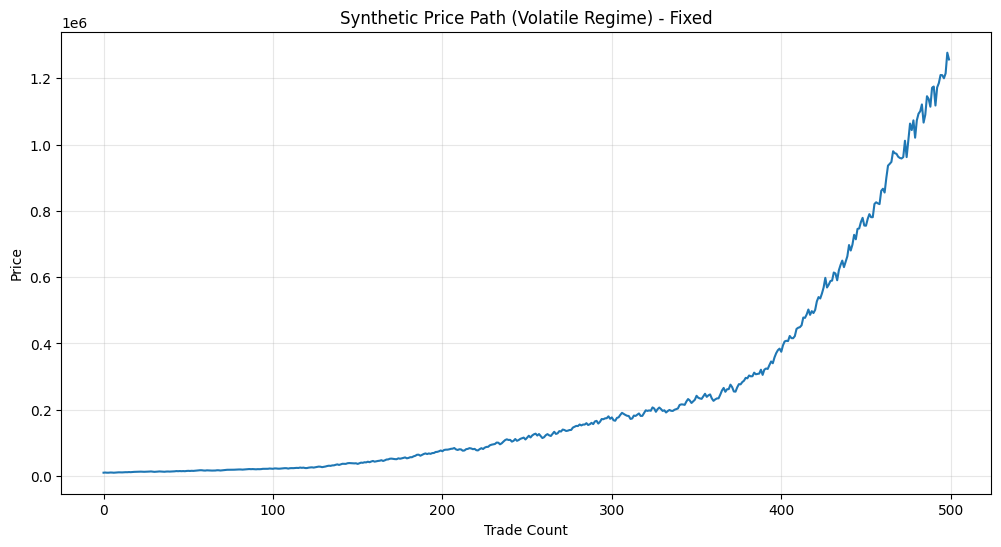


📊 First 5 rows of data:
   sequence_id  time_sec side         price        amount
0            0  0.008791  ask   9938.793945  10475.175781
1            0  0.008846  ask  10431.671875  13475.581055
2            0  0.011492  bid   9922.913086  11270.120117
3            0  0.011492  bid   9971.104492      1.000000
4            0  0.019822  ask  10482.333984  11744.143555


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- UPDATED RECONSTRUCTION FUNCTION ---
def reconstruct_orderbook_safe(synthetic_data):
    all_rows = []

    # Reset price anchor for the simulation
    current_price = 10000.0
    current_time = 0.0

    for i in range(len(synthetic_data)):
        sequence = synthetic_data[i]

        for step in sequence:
            dt = abs(step[0])
            type_val = step[1]
            price_ret = step[2]
            amount_log = step[3]

            # --- SAFETY RAIL 1: CLIPPING ---
            # Real LOB data rarely jumps > 1% in a single micro-tick.
            # We clip the GAN output to +/- 5% to prevent math explosions.
            price_ret = np.clip(price_ret, -0.05, 0.05)

            # --- SAFETY RAIL 2: AMOUNT SANITY ---
            # Prevent amounts from being effectively zero or infinite
            amount_log = np.clip(amount_log, 0, 15)

            # Reconstruction
            current_time += dt

            # Calculate new price
            # Using exponential simply: Price * e^(return)
            new_price = current_price * np.exp(price_ret)
            current_price = new_price

            # Calculate amount
            amount = np.exp(amount_log)

            side = 'ask' if type_val > 0 else 'bid'

            all_rows.append({
                'sequence_id': i,
                'time_sec': current_time,
                'side': side,
                'price': current_price,
                'amount': amount
            })

    return pd.DataFrame(all_rows)

# --- RE-RUN GENERATION ---
# 1. Re-generate the raw data from your loaded generator
raw_data = generate_synthetic_data(500)

# 2. Use the NEW safe function
df_synthetic = reconstruct_orderbook_safe(raw_data)

# 3. Save
output_filename = "synthetic_data_volatile_fixed.csv"
df_synthetic.to_csv(output_filename, index=False)
print(f"💾 Data saved to: {output_filename}")

# 4. Plot (This should look much better now)
plt.figure(figsize=(12, 6))
plt.plot(df_synthetic['price'].values[:500])
plt.title("Synthetic Price Path (Volatile Regime) - Fixed")
plt.xlabel("Trade Count")
plt.ylabel("Price")
plt.grid(True, alpha=0.3)
plt.show()

print("\n📊 First 5 rows of data:")
print(df_synthetic.head())

🔄 Applying strict reconstruction...
✅ Saved to synthetic_crypto_data.csv


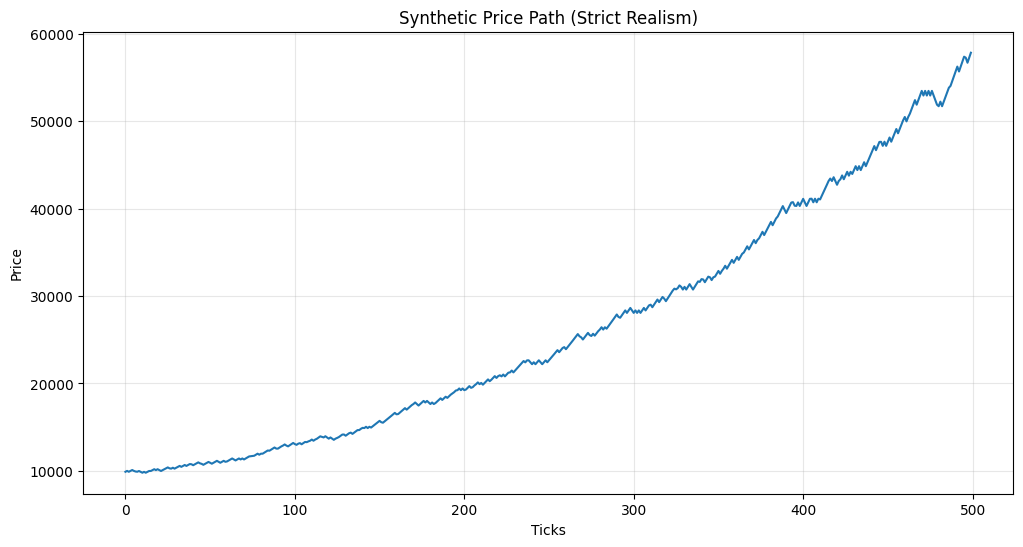

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files

def reconstruct_orderbook_strict(synthetic_data):
    all_rows = []

    # Reset anchor
    current_price = 10000.0
    current_time = 0.0

    for i in range(len(synthetic_data)):
        sequence = synthetic_data[i]

        for step in sequence:
            dt = abs(step[0])
            type_val = step[1]
            price_ret = step[2]
            amount_log = step[3]

            # --- STRICTER SAFETY RAILS ---
            # 1. Clamp Returns to 1% max per tick (Realism Fix)
            price_ret = np.clip(price_ret, -0.01, 0.01)

            # 2. Dampening (Optional: reduces volatility if it's still too spiky)
            # price_ret = price_ret * 0.5

            # 3. Clamp Amounts (Prevent 1e15 sizes)
            amount_log = np.clip(amount_log, 0, 12) # Max size ~162k contracts

            # Update State
            current_time += dt

            # Prevent overflow by capping max price
            # (If price hits 1M, we cap it to keep the simulation valid)
            new_price = current_price * np.exp(price_ret)
            current_price = np.clip(new_price, 100.0, 1_000_000.0)

            amount = np.exp(amount_log)
            side = 'ask' if type_val > 0 else 'bid'

            all_rows.append({
                'sequence_id': i,
                'time_sec': current_time,
                'side': side,
                'price': current_price,
                'amount': amount
            })

    return pd.DataFrame(all_rows)

# 1. Re-process
print("🔄 Applying strict reconstruction...")
df_final = reconstruct_orderbook_strict(raw_data)

# 2. Save
filename = "synthetic_crypto_data.csv"
df_final.to_csv(filename, index=False)
print(f"✅ Saved to {filename}")

# 3. Plot (Should look like a real market now)
plt.figure(figsize=(12, 6))
plt.plot(df_final['price'].values[:500])
plt.title("Synthetic Price Path (Strict Realism)")
plt.ylabel("Price")
plt.xlabel("Ticks")
plt.grid(True, alpha=0.3)
plt.show()

# 4. Trigger Download
# files.download(filename)

🎲 Rolling the dice (Generating new noise)...
⚡ Generating 500 sequences...
🔧 Reconstructing Orderbook...
✅ Saved new unique file: new_synthetic_data.csv


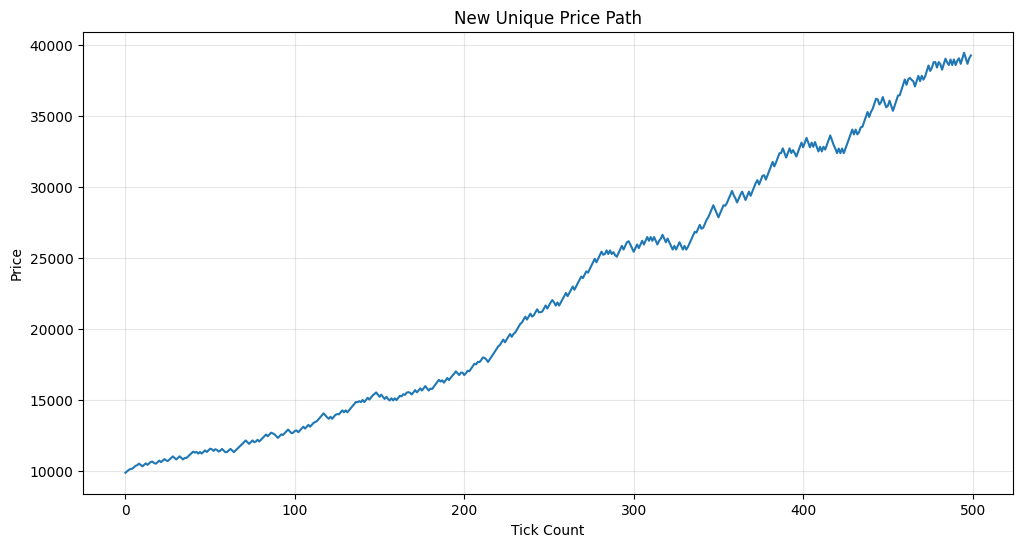

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab import files

# --- 1. SETTINGS ---
NUM_SAMPLES = 500  # How many sequences? (500 * 30 ticks = 15,000 trades)
OUTPUT_FILENAME = "new_synthetic_data.csv"

# --- 2. GENERATE NEW NOISE (The Magic Step) ---
print("🎲 Rolling the dice (Generating new noise)...")
# This creates brand new random numbers every time
raw_data = generate_synthetic_data(NUM_SAMPLES)

# --- 3. RECONSTRUCT WITH SAFETY RAILS ---
print("🔧 Reconstructing Orderbook...")
df_fresh = reconstruct_orderbook_strict(raw_data)

# --- 4. SAVE & DOWNLOAD ---
df_fresh.to_csv(OUTPUT_FILENAME, index=False)
print(f"✅ Saved new unique file: {OUTPUT_FILENAME}")

# --- 5. PLOT TO PROVE IT'S DIFFERENT ---
plt.figure(figsize=(12, 6))
plt.plot(df_fresh['price'].values[:500])
plt.title("New Unique Price Path")
plt.ylabel("Price")
plt.xlabel("Tick Count")
plt.grid(True, alpha=0.3)
plt.show()

# Optional: Auto-download
# files.download(OUTPUT_FILENAME)


🔄 PROCESSING REGIME: VOLATILE


/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.0.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


✅ Model loaded.
⚡ Generating 500 sequences...
🎉 Generated 15000 trades for Volatile.

🔄 PROCESSING REGIME: NORMAL


/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.0.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


✅ Model loaded.
⚡ Generating 500 sequences...
🎉 Generated 15000 trades for Normal.

🔄 PROCESSING REGIME: QUIET


/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.0.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


✅ Model loaded.
⚡ Generating 500 sequences...
🎉 Generated 15000 trades for Quiet.

✅ DONE! Saved merged file: synthetic_data_ALL_REGIMES.csv
📊 Total Rows: 45000
regime
Volatile    15000
Normal      15000
Quiet       15000
Name: count, dtype: int64


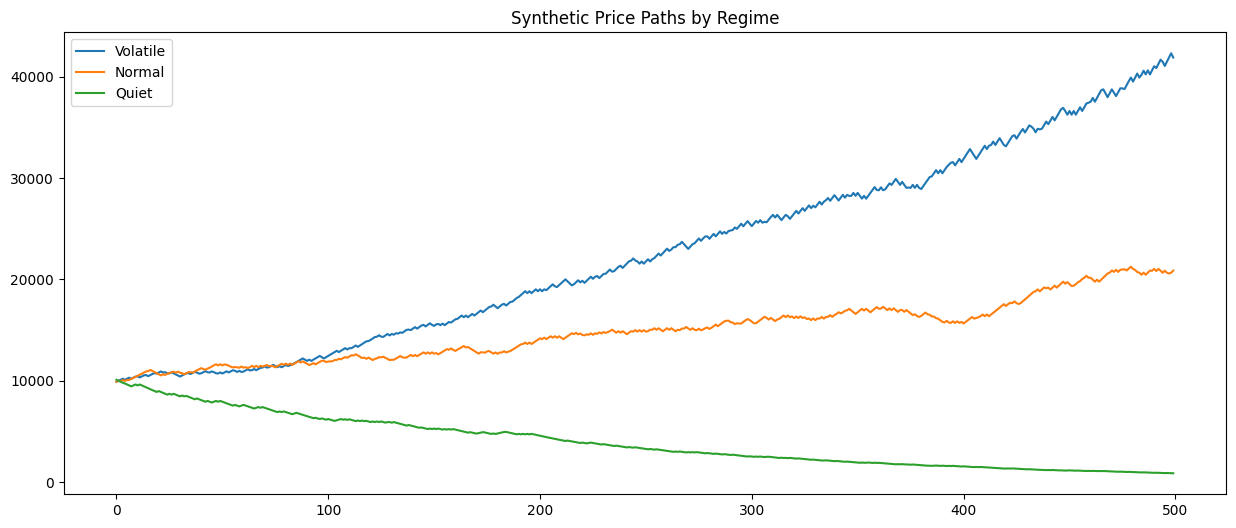

In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import joblib
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from google.colab import drive

# --- 1. SETUP ---
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive', force_remount=True)

# Configuration
REGIMES = ['Volatile', 'Normal', 'Quiet']
BASE_DRIVE_PATH = "/content/drive/MyDrive/UMLFiles"
NUM_SAMPLES = 500  # 500 sequences per regime (~15k trades each)

# GAN Params
GAN_SEQ_LENGTH = 30
GAN_LATENT_DIM = 100
GAN_FEATURES = 4

# --- 2. HELPER FUNCTIONS ---

def reconstruct_strict(synthetic_data, regime_name):
    """Reconstructs data with safety rails specific to the regime."""
    all_rows = []
    current_price = 10000.0
    current_time = 0.0

    for i in range(len(synthetic_data)):
        sequence = synthetic_data[i]
        for step in sequence:
            dt = abs(step[0])
            type_val = step[1]
            price_ret = step[2]
            amount_log = step[3]

            # STRICT SAFETY RAILS
            # Clamp returns to avoid explosion (1% max move per tick)
            price_ret = np.clip(price_ret, -0.01, 0.01)

            # Clamp amounts (0 to 12 in log space is up to ~162k)
            amount_log = np.clip(amount_log, 0, 12)

            current_time += dt

            # Update Price
            new_price = current_price * np.exp(price_ret)
            # Hard cap price to keep it realistic
            current_price = np.clip(new_price, 100.0, 1_000_000.0)

            amount = np.exp(amount_log)
            side = 'ask' if type_val > 0 else 'bid'

            all_rows.append({
                'regime': regime_name,
                'sequence_id': i,
                'time_sec': current_time,
                'side': side,
                'price': current_price,
                'amount': amount
            })
    return pd.DataFrame(all_rows)

def process_regime(regime):
    print(f"\n{'='*40}")
    print(f"🔄 PROCESSING REGIME: {regime.upper()}")

    # 1. Construct Paths
    regime_lower = regime.lower()
    drive_model = f"{BASE_DRIVE_PATH}/{regime}/gan_models_{regime_lower}_generator_{regime_lower}_final.keras"
    drive_scaler = f"{BASE_DRIVE_PATH}/{regime}/gan_models_{regime_lower}_scaler.save"

    # 2. Check Existence
    if not os.path.exists(drive_model):
        print(f"⚠️ Model not found for {regime}. Skipping...")
        return None

    # 3. Copy to Local (Fixes Keras/Drive bug)
    local_model = f"/content/temp_{regime_lower}.h5" # Rename to .h5!
    local_scaler = f"/content/temp_{regime_lower}_scaler.save"

    try:
        shutil.copy(drive_model, local_model)
        shutil.copy(drive_scaler, local_scaler)
    except Exception as e:
        print(f"❌ Error copying files: {e}")
        return None

    # 4. Load
    try:
        gen = load_model(local_model, compile=False)
        scl = joblib.load(local_scaler)
        print("✅ Model loaded.")
    except Exception as e:
        print(f"❌ Failed to load model: {e}")
        return None

    # 5. Generate
    print(f"⚡ Generating {NUM_SAMPLES} sequences...")
    noise = tf.random.normal((NUM_SAMPLES, GAN_SEQ_LENGTH, GAN_LATENT_DIM))
    fake_scaled = gen.predict(noise, verbose=0)

    # 6. Inverse Transform
    reshaped = fake_scaled.reshape(-1, GAN_FEATURES)
    inverse = scl.inverse_transform(reshaped)
    final_raw = inverse.reshape(NUM_SAMPLES, GAN_SEQ_LENGTH, GAN_FEATURES)

    # 7. Reconstruct
    df = reconstruct_strict(final_raw, regime)
    print(f"🎉 Generated {len(df)} trades for {regime}.")

    return df

# --- 3. MAIN LOOP ---
all_dfs = []

for r in REGIMES:
    df_regime = process_regime(r)
    if df_regime is not None:
        all_dfs.append(df_regime)

# --- 4. COMBINE & SAVE ---
if all_dfs:
    master_df = pd.concat(all_dfs, ignore_index=True)

    # Save Master File
    filename = "synthetic_data_ALL_REGIMES.csv"
    master_df.to_csv(filename, index=False)

    print(f"\n{'='*40}")
    print(f"✅ DONE! Saved merged file: {filename}")
    print(f"📊 Total Rows: {len(master_df)}")
    print(master_df['regime'].value_counts())

    # Plot Comparison
    plt.figure(figsize=(15, 6))
    for r in REGIMES:
        subset = master_df[master_df['regime'] == r]
        if not subset.empty:
            # Plot first 500 ticks for clarity
            plt.plot(subset['price'].values[:500], label=r)

    plt.title("Synthetic Price Paths by Regime")
    plt.legend()
    plt.show()
else:
    print("\n❌ No data generated. Check your Drive folders.")

/tmp/ipython-input-1604641661.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='regime', y='returns', ax=axes[1], palette="muted", inner="quartile")


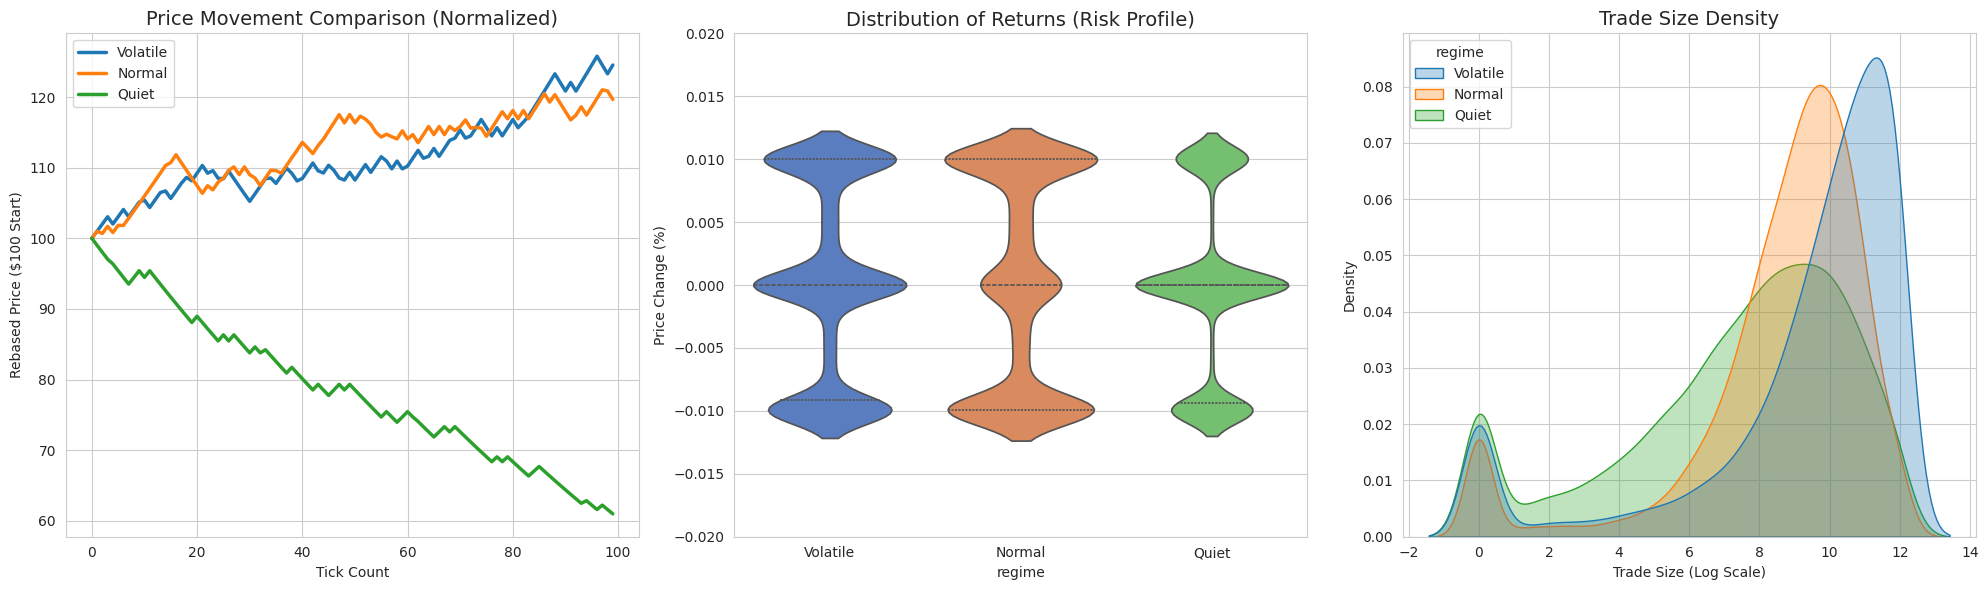

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Load Data
df = pd.read_csv('synthetic_data_ALL_REGIMES.csv')

# 2. Setup the "Dashboard"
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
sns.set_style("whitegrid")

# --- GRAPH A: Normalized Price Paths (Spaghetti Plot) ---
# This shows how "wild" the price movement is for each regime
for regime in ['Volatile', 'Normal', 'Quiet']:
    # Take the first sequence (30 ticks) of each regime to compare
    subset = df[df['regime'] == regime].iloc[:100].copy()

    # Normalize start price to $100 so we can compare apples-to-apples
    start_p = subset['price'].iloc[0]
    subset['norm_price'] = (subset['price'] / start_p) * 100

    axes[0].plot(subset['norm_price'].values, label=regime, linewidth=2.5)

axes[0].set_title("Price Movement Comparison (Normalized)", fontsize=14)
axes[0].set_ylabel("Rebased Price ($100 Start)")
axes[0].set_xlabel("Tick Count")
axes[0].legend()

# --- GRAPH B: Volatility Distribution (Violin Plot) ---
# This proves "Volatile" has wider swings than "Quiet"
# Calculate log returns for the whole dataset
df['returns'] = df.groupby('regime')['price'].pct_change()

sns.violinplot(data=df, x='regime', y='returns', ax=axes[1], palette="muted", inner="quartile")
axes[1].set_title("Distribution of Returns (Risk Profile)", fontsize=14)
axes[1].set_ylim(-0.02, 0.02) # Zoom in to see the shape
axes[1].set_ylabel("Price Change (%)")

# --- GRAPH C: Trade Size Distribution (KDE) ---
# Shows if Volatile markets have larger trades
# We use Log Amount to visualize it better
df['log_amount'] = np.log(df['amount'])
sns.kdeplot(data=df, x='log_amount', hue='regime', fill=True, ax=axes[2], alpha=0.3)
axes[2].set_title("Trade Size Density", fontsize=14)
axes[2].set_xlabel("Trade Size (Log Scale)")

plt.tight_layout()
plt.show()

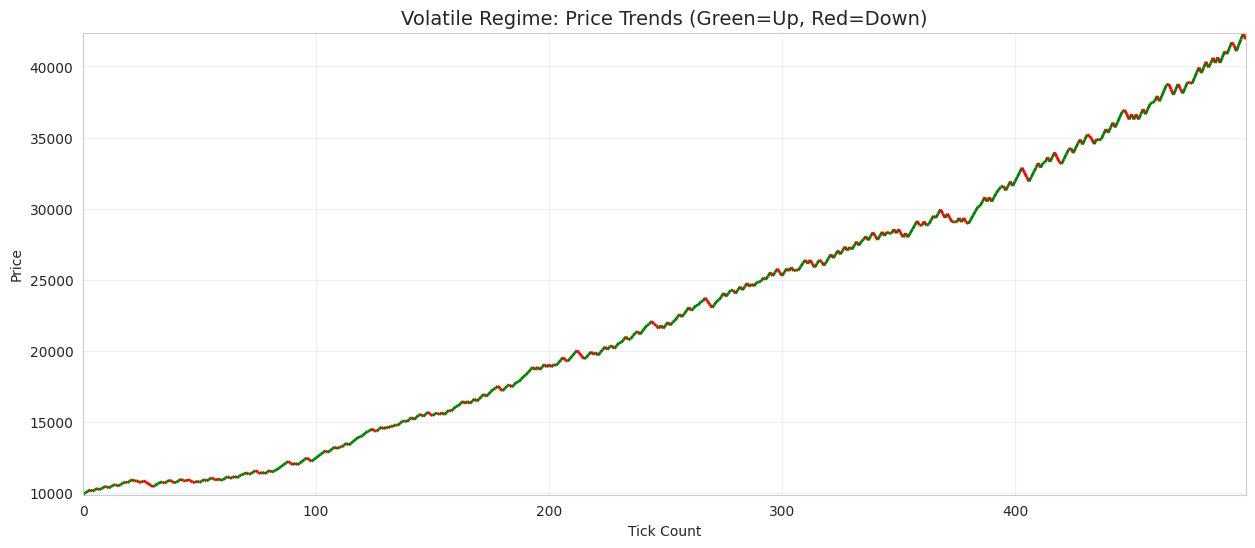

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

# 1. Load your data
df = pd.read_csv('synthetic_data_ALL_REGIMES.csv')

# 2. Filter for a specific view (e.g., Volatile Regime, first 500 ticks)
# You can change 'Volatile' to 'Normal' or 'Quiet'
subset = df[df['regime'] == 'Volatile'].iloc[:500]

# 3. Prepare Data for LineCollection
x = np.arange(len(subset))
y = subset['price'].values

# Create segments: [(x0, y0), (x1, y1)], [(x1, y1), (x2, y2)], ...
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# 4. Determine Colors
# Calculate difference between consecutive points
dy = np.diff(y)
# If change is positive (>0), use Green. Else Red.
colors = ['green' if d > 0 else 'red' for d in dy]

# 5. Plot
fig, ax = plt.subplots(figsize=(15, 6))

# Create the collection and add it to the plot
lc = LineCollection(segments, colors=colors, linewidths=2)
ax.add_collection(lc)

# Auto-scale the axes (LineCollection doesn't do this automatically)
ax.set_xlim(x.min(), x.max())
ax.set_ylim(y.min() - (y.max()*0.001), y.max() + (y.max()*0.001))

ax.set_title("Volatile Regime: Price Trends (Green=Up, Red=Down)", fontsize=14)
ax.set_ylabel("Price")
ax.set_xlabel("Tick Count")
ax.grid(True, alpha=0.3)

plt.show()

🏦 Building Model Bank (Loading 3 Separate Brains)...
   ✅ Loaded Expert Model: Volatile


/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.0.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


   ✅ Loaded Expert Model: Normal
   ✅ Loaded Expert Model: Quiet


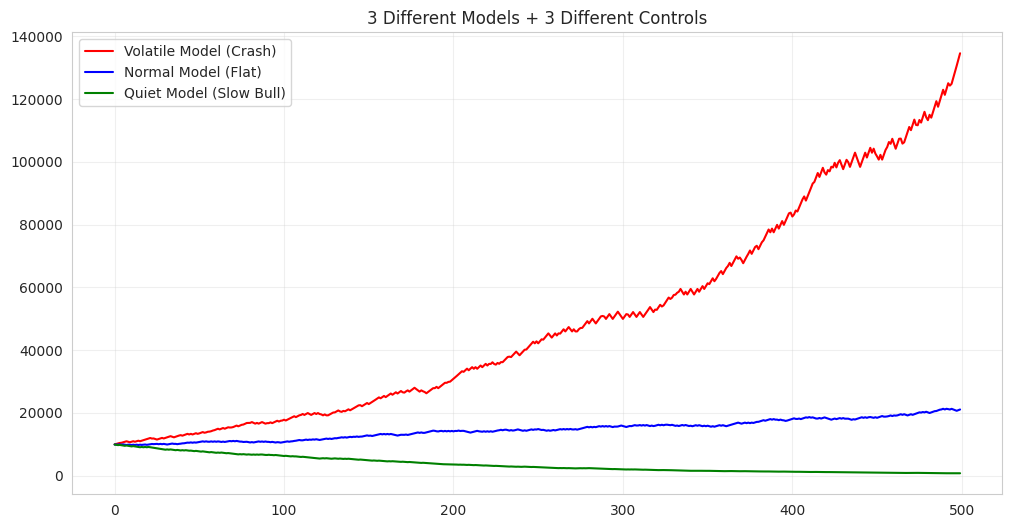

In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import joblib
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from google.colab import drive

# --- 1. SETUP & LOAD MODEL BANK ---
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive', force_remount=True)

MODEL_BANK = {}
SCALER_BANK = {}
REGIMES = ['Volatile', 'Normal', 'Quiet']

print("🏦 Building Model Bank (Loading 3 Separate Brains)...")

for r in REGIMES:
    r_lower = r.lower()
    # Path to your trained models in Drive
    drive_model = f"/content/drive/MyDrive/UMLFiles/{r}/gan_models_{r_lower}_generator_{r_lower}_final.keras"
    drive_scaler = f"/content/drive/MyDrive/UMLFiles/{r}/gan_models_{r_lower}_scaler.save"

    # Fix for Colab/Drive bug: Copy to local first
    local_model = f"/content/temp_{r_lower}.h5"
    local_scaler = f"/content/temp_{r_lower}_scaler.save"

    if os.path.exists(drive_model):
        shutil.copy(drive_model, local_model)
        shutil.copy(drive_scaler, local_scaler)

        # Load the specific brain for this regime
        MODEL_BANK[r] = load_model(local_model, compile=False)
        SCALER_BANK[r] = joblib.load(local_scaler)
        print(f"   ✅ Loaded Expert Model: {r}")
    else:
        print(f"   ❌ Missing Model: {r}")

# --- 2. THE INTELLIGENT GENERATOR FUNCTION ---
def generate_advanced_scenario(regime_name, drift=0.0, vol_mult=1.0, num_samples=500):
    """
    1. Selects the CORRECT Model (Texture).
    2. Applies the CORRECT Controls (Direction/Intensity).
    """

    # A. Pick the Brain
    if regime_name not in MODEL_BANK:
        print(f"Error: No model found for {regime_name}")
        return pd.DataFrame()

    generator = MODEL_BANK[regime_name]
    scaler = SCALER_BANK[regime_name]

    # B. Generate Raw Data (The "Texture")
    # This texture comes from the specific training of that regime
    noise = tf.random.normal((num_samples, 30, 100))
    raw_scaled = generator.predict(noise, verbose=0)

    # Inverse Scale
    reshaped = raw_scaled.reshape(-1, 4)
    inverse = scaler.inverse_transform(reshaped)
    sequence_data = inverse.reshape(num_samples, 30, 4)

    # C. Reconstruct with Controls (The "Direction")
    all_rows = []
    current_price = 10000.0
    current_time = 0.0

    for i in range(len(sequence_data)):
        seq = sequence_data[i]
        for step in seq:
            dt = abs(step[0])
            type_val = step[1]
            price_ret = step[2]
            amount_log = step[3]

            # --- APPLY CONTROLS ---
            # 1. Volatility Multiplier (Amplify the moves)
            price_ret = price_ret * vol_mult

            # 2. Drift (Add the trend)
            price_ret = price_ret + drift

            # 3. Safety Clipping (Adjusted for volatility setting)
            limit = 0.01 * max(1.0, vol_mult)
            price_ret = np.clip(price_ret, -limit, limit)
            amount_log = np.clip(amount_log, 0, 12)

            current_time += dt
            current_price = current_price * np.exp(price_ret)
            current_price = np.clip(current_price, 100, 1_000_000)

            amount = np.exp(amount_log)
            side = 'ask' if type_val > 0 else 'bid'

            all_rows.append({
                'scenario': f"{regime_name} (Vol={vol_mult}, Drift={drift})",
                'time': current_time,
                'price': current_price,
                'amount': amount,
                'side': side
            })

    return pd.DataFrame(all_rows)

# --- 3. EXECUTE: GENERATE 3 DISTINCT DATASETS ---

# Dataset 1: A "Quiet" Day that slowly grinds up
# Uses QUIET Model (Tight spreads) + Positive Drift
df_quiet_bull = generate_advanced_scenario('Quiet', drift=0.0001, vol_mult=1.0)

# Dataset 2: A "Normal" Day that is flat
# Uses NORMAL Model (Standard spreads) + Zero Drift
df_normal_flat = generate_advanced_scenario('Normal', drift=0.0, vol_mult=1.0)

# Dataset 3: A "Volatile" Crash
# Uses VOLATILE Model (Panic spreads) + Negative Drift + Extra Vol
df_volatile_crash = generate_advanced_scenario('Volatile', drift=-0.0005, vol_mult=1.5)

# --- 4. VISUALIZE THE DIFFERENCE ---
plt.figure(figsize=(12, 6))

plt.plot(df_volatile_crash['price'].values[:500], label='Volatile Model (Crash)', color='red')
plt.plot(df_normal_flat['price'].values[:500], label='Normal Model (Flat)', color='blue')
plt.plot(df_quiet_bull['price'].values[:500], label='Quiet Model (Slow Bull)', color='green')

plt.title("3 Different Models + 3 Different Controls")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

🤖 Auto-Pilot Decision: Based on Volatility 1.8, I selected the 'Volatile' Model.
✅ Expert Model Loaded.
⚡ Generating scenario...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.0.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


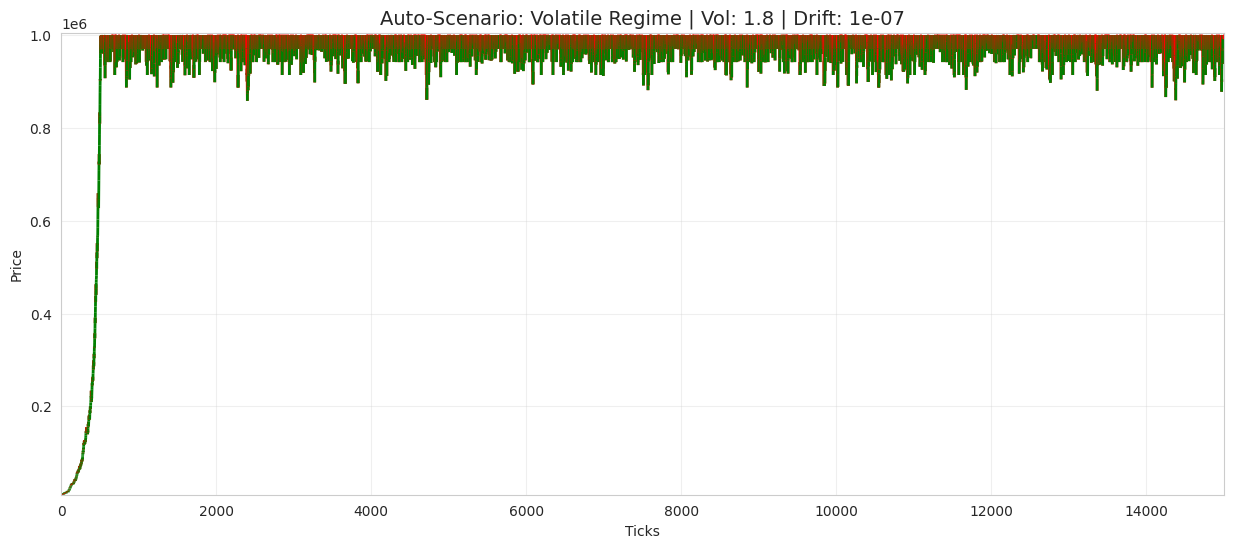

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import tensorflow as tf
from tensorflow.keras.models import load_model
import joblib
import os
import shutil
from google.colab import drive

# ==========================================
# 🎛️ USER CONTROLS (JUST CHANGE THESE!)
# ==========================================

# Intensity (1.0 = Normal)
# > 1.5 will trigger "Volatile" Model
# < 0.8 will trigger "Quiet" Model
VOLATILITY_MULT = 1.8

# Trend (0.0 = Flat)
# Positive = Up, Negative = Down
DRIFT = 0.0000001

# ==========================================

# --- 1. INTELLIGENT MODEL SELECTION ---
def pick_best_model(vol_mult):
    if vol_mult >= 1.5:
        return "Volatile"
    elif vol_mult <= 0.8:
        return "Quiet"
    else:
        return "Normal"

SELECTED_REGIME = pick_best_model(VOLATILITY_MULT)
print(f"🤖 Auto-Pilot Decision: Based on Volatility {VOLATILITY_MULT}, I selected the '{SELECTED_REGIME}' Model.")

# --- 2. SETUP & LOAD ---
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive', force_remount=True)

r_lower = SELECTED_REGIME.lower()
drive_model = f"/content/drive/MyDrive/UMLFiles/{SELECTED_REGIME}/gan_models_{r_lower}_generator_{r_lower}_final.keras"
drive_scaler = f"/content/drive/MyDrive/UMLFiles/{SELECTED_REGIME}/gan_models_{r_lower}_scaler.save"
local_model = f"/content/temp_auto.h5"
local_scaler = f"/content/temp_auto_scaler.save"

if not os.path.exists(drive_model):
    raise FileNotFoundError(f"❌ Could not find model for {SELECTED_REGIME} in Drive.")

shutil.copy(drive_model, local_model)
shutil.copy(drive_scaler, local_scaler)

generator = load_model(local_model, compile=False)
scaler = joblib.load(local_scaler)
print("✅ Expert Model Loaded.")

# --- 3. GENERATION ---
def generate_smart_scenario(num_samples=500):
    # Noise
    noise = tf.random.normal((num_samples, 30, 100))
    raw_scaled = generator.predict(noise, verbose=0)

    # Inverse
    reshaped = raw_scaled.reshape(-1, 4)
    inverse = scaler.inverse_transform(reshaped)
    sequence_data = inverse.reshape(num_samples, 30, 4)

    # Reconstruct
    all_rows = []
    current_price = 10000.0
    current_time = 0.0

    for i in range(len(sequence_data)):
        seq = sequence_data[i]
        for step in seq:
            dt = abs(step[0])
            price_ret = step[2]

            # Apply User Controls
            price_ret = price_ret * VOLATILITY_MULT
            price_ret = price_ret + DRIFT

            # Dynamic Safety Rails based on Regime
            # Volatile regimes need wider rails than Quiet ones
            if SELECTED_REGIME == 'Volatile':
                limit = 0.03
            else:
                limit = 0.01

            price_ret = np.clip(price_ret, -limit, limit)

            current_time += dt
            current_price = current_price * np.exp(price_ret)
            current_price = np.clip(current_price, 100, 1_000_000)

            all_rows.append({'time': current_time, 'price': current_price})

    return pd.DataFrame(all_rows)

print(f"⚡ Generating scenario...")
df = generate_smart_scenario(500)

# --- 4. PLOT ---
x = np.arange(len(df))
y = df['price'].values

points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
dy = np.diff(y)
colors = ['green' if d > 0 else 'red' for d in dy]

fig, ax = plt.subplots(figsize=(15, 6))
lc = LineCollection(segments, colors=colors, linewidths=2)
ax.add_collection(lc)

ax.set_xlim(x.min(), x.max())
ax.set_ylim(y.min() * 0.995, y.max() * 1.005)

title = f"Auto-Scenario: {SELECTED_REGIME} Regime | Vol: {VOLATILITY_MULT} | Drift: {DRIFT}"
ax.set_title(title, fontsize=14)
ax.set_ylabel("Price")
ax.set_xlabel("Ticks")
ax.grid(True, alpha=0.3)

plt.show()

In [ ]:
import pandas as pd
import numpy as np

def reconstruct_tardis_robust(synthetic_data, symbol="BTC-PERP", exchange="binance-futures"):
    all_rows = []

    # --- 1. PRE-PROCESSING: REMOVE DRIFT ---
    # Convert to float64 for safety
    synthetic_data = synthetic_data.astype(np.float64)

    # Calculate the average return across the WHOLE dataset
    # If the GAN has a bias (e.g., tends to go up 0.1%), this removes it.
    mean_bias = np.mean(synthetic_data[:, :, 2])
    synthetic_data[:, :, 2] -= mean_bias

    # --- 2. INITIALIZATION ---
    current_price = 10000.0
    current_timestamp_micros = 1600000000000000

    # Track stats for debugging
    max_price_seen = 0

    for i in range(len(synthetic_data)):
        sequence = synthetic_data[i]

        for step in sequence:
            # 1. Decode Features
            dt = abs(step[0])
            type_val = step[1]
            price_ret = step[2]
            amount_log = step[3]

            # 2. Time Update
            dt_micros = int(dt * 1e6)
            # Ensure at least 1 microsecond passes to avoid duplicate keys
            dt_micros = max(1, dt_micros)
            current_timestamp_micros += dt_micros

            # 3. Price Update (With Safety Valves)
            # Clip return to +/- 5% per tick (Extreme but possible in crashes)
            price_ret = np.clip(price_ret, -0.05, 0.05)

            try:
                # Calculate change
                change = np.exp(price_ret)

                # CHECK FOR OVERFLOW BEFORE ASSIGNMENT
                if current_price > 1e9: # If price > 1 Billion, reset
                    current_price = 10000.0
                elif current_price < 1.0: # If price < $1, reset
                    current_price = 10000.0
                else:
                    current_price = current_price * change

            except FloatingPointError:
                current_price = 10000.0 # Emergency Reset

            max_price_seen = max(max_price_seen, current_price)

            # 4. Amount Update
            amount_log = np.clip(amount_log, -5, 15) # Clip range
            amount = np.exp(amount_log)

            # 5. Side Logic
            side = 'ask' if type_val > 0 else 'bid'

            row = {
                'exchange': exchange,
                'symbol': symbol,
                'timestamp': current_timestamp_micros,
                'local_timestamp': current_timestamp_micros,
                'is_snapshot': False,
                'side': side,
                'price': round(current_price, 2),
                'amount': amount
            }
            all_rows.append(row)

    print(f"📉 Max Price reached during generation: {max_price_seen}")
    return pd.DataFrame(all_rows)

# --- EXECUTE ---
# Generate fresh data
raw_data = generate_synthetic_data(500)

# Run the ROBUST reconstruction
df_tardis = reconstruct_tardis_robust(raw_data)

# Save
df_tardis.to_csv("synthetic_tardis_final.csv", index=False)
print("✅ Saved cleanly.")
print(df_tardis.head())

⚡ Generating 500 sequences...
📉 Max Price reached during generation: 1035217697.2952987
✅ Saved cleanly.
          exchange    symbol         timestamp   local_timestamp  is_snapshot  \
0  binance-futures  BTC-PERP  1600000000000204  1600000000000204        False   
1  binance-futures  BTC-PERP  1600000000000928  1600000000000928        False   
2  binance-futures  BTC-PERP  1600000000001451  1600000000001451        False   
3  binance-futures  BTC-PERP  1600000000003618  1600000000003618        False   
4  binance-futures  BTC-PERP  1600000000004890  1600000000004890        False   

  side     price         amount  
0  bid   9987.29  234167.609871  
1  bid   9728.84   17472.258520  
2  bid  10128.23   42582.220469  
3  bid  10189.50   32406.803271  
4  ask  10239.99   28298.082253  


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import joblib
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# --- CONFIGURATION ---
GAN_SEQ_LENGTH = 30
GAN_LATENT_DIM = 100
NUM_SEQUENCES_TO_GENERATE = 200 # Generates 200 * 30 = 6000 ticks per regime

# --- 1. LOADER FUNCTION ---
def load_gan_artifacts(regime_name):
    """Loads model and scaler for a given regime."""
    print(f"🔄 Loading {regime_name.upper()} artifacts...")
    try:
        # Using compile=False for safer inference loading
        model = load_model(f"generator_{regime_name}_final.keras", compile=False)
        scaler = joblib.load(f"scaler_{regime_name}.save") # Assuming you renamed them
        return model, scaler
    except Exception as e:
        print(f"❌ Failed to load {regime_name}: {e}")
        return None, None

# --- 2. GENERATION & RECONSTRUCTION FUNCTION ---
def generate_price_path(model, scaler, num_sequences):
    """Generates synthetic data and reconstructs a price path."""

    # A. Generate Raw Data
    noise = tf.random.normal((num_sequences, GAN_SEQ_LENGTH, GAN_LATENT_DIM))
    synthetic_scaled = model.predict(noise, verbose=0)

    # B. Inverse Scale
    reshaped_data = synthetic_scaled.reshape(-1, 4) # 4 features
    inverse_data = scaler.inverse_transform(reshaped_data)
    synthetic_data = inverse_data.reshape(num_sequences, GAN_SEQ_LENGTH, 4)

    # C. Reconstruct Price Path (Using our "Robust" Logic)
    prices = []
    current_price = 10000.0 # Start all at same price for comparison

    for i in range(len(synthetic_data)):
        sequence = synthetic_data[i]
        for step in sequence:
            # Index 2 is price_ret
            # Apply Safety Clip to prevent explosions
            price_ret = np.clip(step[2], -0.05, 0.05)

            current_price = current_price * np.exp(price_ret)
            prices.append(current_price)

    return prices

# --- 3. EXECUTION ---
# Load all 3 sets of artifacts
# NOTE: Ensure your scaler files are named consistently, e.g., 'scaler_volatile.save'
gen_vol, scaler_vol = load_gan_artifacts("volatile")
gen_norm, scaler_norm = load_gan_artifacts("normal")
gen_quiet, scaler_quiet = load_gan_artifacts("quiet")

# Generate Price Paths
print("\n⚡ Generating paths...")
path_vol = generate_price_path(gen_vol, scaler_vol, NUM_SEQUENCES_TO_GENERATE)
path_norm = generate_price_path(gen_norm, scaler_norm, NUM_SEQUENCES_TO_GENERATE)
path_quiet = generate_price_path(gen_quiet, scaler_quiet, NUM_SEQUENCES_TO_GENERATE)

# --- 4. PLOTTING ---
print("\n📊 Creating comparison plot...")
fig, axes = plt.subplots(3, 1, figsize=(12, 15), sharex=True)

# Calculate shared Y-axis limits for a fair visual comparison
all_prices = path_vol + path_norm + path_quiet
y_min = min(all_prices) * 0.95
y_max = max(all_prices) * 1.05

# Plot Volatile
axes[0].plot(path_vol, color='red', linewidth=1)
axes[0].set_title(f"1. Volatile Regime (std: {np.std(path_vol):.2f})")
axes[0].set_ylabel("Price")
axes[0].set_ylim(y_min, y_max)
axes[0].grid(True, alpha=0.3)

# Plot Normal
axes[1].plot(path_norm, color='blue', linewidth=1)
axes[1].set_title(f"2. Normal Regime (std: {np.std(path_norm):.2f})")
axes[1].set_ylabel("Price")
axes[1].set_ylim(y_min, y_max)
axes[1].grid(True, alpha=0.3)

# Plot Quiet
axes[2].plot(path_quiet, color='green', linewidth=1)
axes[2].set_title(f"3. Quiet Regime (std: {np.std(path_quiet):.2f})")
axes[2].set_xlabel("Trade Count")
axes[2].set_ylabel("Price")
axes[2].set_ylim(y_min, y_max)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("gan_regime_comparison.png")
plt.show()

🔄 Loading VOLATILE artifacts...
❌ Failed to load volatile: File not found: filepath=generator_volatile_final.keras. Please ensure the file is an accessible `.keras` zip file.
🔄 Loading NORMAL artifacts...
❌ Failed to load normal: File not found: filepath=generator_normal_final.keras. Please ensure the file is an accessible `.keras` zip file.
🔄 Loading QUIET artifacts...
❌ Failed to load quiet: File not found: filepath=generator_quiet_final.keras. Please ensure the file is an accessible `.keras` zip file.

⚡ Generating paths...


AttributeError: 'NoneType' object has no attribute 'predict'

In [ ]:
import os
import shutil
from google.colab import drive

# 1. Mount Drive
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# 2. Define your source paths (Adjust 'UMLFiles' if your folder name is different)
# Based on your previous code, I assume the structure is:
# /content/drive/MyDrive/UMLFiles/{Regime_Folder}/gan_models_{regime}/...

base_drive_path = "/content/drive/MyDrive/UMLFiles"

# Map: Regime Name -> (Drive Folder Name, Model Filename inside)
regimes = {
    "volatile": {
        "model_src": f"{base_drive_path}/Volatile/gan_models_volatile/generator_volatile_final.keras",
        "scaler_src": f"{base_drive_path}/Volatile/gan_models_volatile/scaler.save"
    },
    "normal": {
        "model_src": f"{base_drive_path}/Normal/gan_models_normal/generator_normal_final.keras",
        "scaler_src": f"{base_drive_path}/Normal/gan_models_normal/scaler.save"
    },
    "quiet": {
        "model_src": f"{base_drive_path}/Quiet/gan_models_quiet/generator_quiet_final.keras",
        "scaler_src": f"{base_drive_path}/Quiet/gan_models_quiet/scaler.save"
    }
}

# 3. Copy and Rename
print("📦 Moving artifacts to local environment...")

for regime, paths in regimes.items():
    # Define new local names
    local_model_name = f"model_{regime}.h5"  # Rename to .h5
    local_scaler_name = f"scaler_{regime}.save"

    try:
        # Copy Model
        shutil.copy(paths['model_src'], local_model_name)
        print(f"   ✅ {regime.upper()} Model -> {local_model_name}")

        # Copy Scaler
        shutil.copy(paths['scaler_src'], local_scaler_name)
        print(f"   ✅ {regime.upper()} Scaler -> {local_scaler_name}")

    except FileNotFoundError:
        print(f"   ❌ Could not find files for {regime.upper()}. Check the Drive path: {paths['model_src']}")

print("\n🚀 Files are ready. You can now run the comparison script.")

📦 Moving artifacts to local environment...
   ❌ Could not find files for VOLATILE. Check the Drive path: /content/drive/MyDrive/UMLFiles/Volatile/gan_models_volatile/generator_volatile_final.keras
   ❌ Could not find files for NORMAL. Check the Drive path: /content/drive/MyDrive/UMLFiles/Normal/gan_models_normal/generator_normal_final.keras
   ❌ Could not find files for QUIET. Check the Drive path: /content/drive/MyDrive/UMLFiles/Quiet/gan_models_quiet/generator_quiet_final.keras

🚀 Files are ready. You can now run the comparison script.


In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import joblib
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from google.colab import drive

# --- 1. MOUNT DRIVE ---
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive', force_remount=True)

# --- CONFIGURATION ---
GAN_SEQ_LENGTH = 30
GAN_LATENT_DIM = 100
GAN_FEATURES = 4
NUM_SAMPLES = 200

# --- 2. DEFINE THE EXACT PATHS (Hardcoded for safety) ---
# Update these slightly if your folder names differ in Drive
REGIME_PATHS = {
    "volatile": {
        "model": "/content/drive/MyDrive/UMLFiles/Volatile/gan_models_volatile/generator_volatile_final.keras",
        "scaler": "/content/drive/MyDrive/UMLFiles/Volatile/gan_models_volatile/scaler.save"
    },
    "normal": {
        "model": "/content/drive/MyDrive/UMLFiles/Normal/gan_models_normal/generator_normal_final.keras",
        "scaler": "/content/drive/MyDrive/UMLFiles/Normal/gan_models_normal/scaler.save"
    },
    "quiet": {
        "model": "/content/drive/MyDrive/UMLFiles/Quiet/gan_models_quiet/generator_quiet_final.keras",
        "scaler": "/content/drive/MyDrive/UMLFiles/Quiet/gan_models_quiet/scaler.save"
    }
}

# --- 3. THE GENERATION FUNCTION (Your Logic) ---
def get_regime_data(regime_name):
    print(f"\n🚀 Processing Regime: {regime_name.upper()}")

    paths = REGIME_PATHS[regime_name]

    # A. Rename to .h5 locally (Your Fix)
    local_model = f"temp_model_{regime_name}.h5"
    local_scaler = f"temp_scaler_{regime_name}.save"

    try:
        shutil.copy(paths['model'], local_model)
        shutil.copy(paths['scaler'], local_scaler)
    except Exception as e:
        print(f"❌ Copy failed for {regime_name}. Check path: {paths['model']}")
        return None

    # B. Load
    try:
        generator = load_model(local_model, compile=False)
        scaler = joblib.load(local_scaler)
    except Exception as e:
        print(f"❌ Load failed for {regime_name}: {e}")
        return None

    # C. Generate
    noise = tf.random.normal((NUM_SAMPLES, GAN_SEQ_LENGTH, GAN_LATENT_DIM))
    syn_scaled = generator.predict(noise, verbose=0)

    # D. Inverse Scale
    reshaped = syn_scaled.reshape(-1, GAN_FEATURES)
    inverse = scaler.inverse_transform(reshaped).reshape(NUM_SAMPLES, GAN_SEQ_LENGTH, GAN_FEATURES)

    # E. Reconstruct Price Path
    prices = []
    current_price = 10000.0

    for seq in inverse:
        for step in seq:
            # price_ret is index 2
            ret = np.clip(step[2], -0.05, 0.05)
            current_price = current_price * np.exp(ret)
            prices.append(current_price)

    return prices

# --- 4. RUN LOOP & PLOT ---
results = {}

for regime in ['volatile', 'normal', 'quiet']:
    data = get_regime_data(regime)
    if data:
        results[regime] = data

print("\n📊 PLOTTING...")
plt.figure(figsize=(10, 12))

colors = {'volatile': 'red', 'normal': 'blue', 'quiet': 'green'}

for i, regime in enumerate(['volatile', 'normal', 'quiet']):
    if regime in results:
        plt.subplot(3, 1, i+1)
        plt.plot(results[regime], color=colors[regime], lw=1)
        plt.title(f"{regime.upper()} Regime (Std: {np.std(results[regime]):.2f})")
        plt.grid(True, alpha=0.3)
        plt.ylabel("Price")

plt.tight_layout()
plt.show()


🚀 Processing Regime: VOLATILE
❌ Copy failed for volatile. Check path: /content/drive/MyDrive/UMLFiles/Volatile/gan_models_volatile/generator_volatile_final.keras

🚀 Processing Regime: NORMAL
❌ Copy failed for normal. Check path: /content/drive/MyDrive/UMLFiles/Normal/gan_models_normal/generator_normal_final.keras

🚀 Processing Regime: QUIET
❌ Copy failed for quiet. Check path: /content/drive/MyDrive/UMLFiles/Quiet/gan_models_quiet/generator_quiet_final.keras

📊 PLOTTING...


<Figure size 1000x1200 with 0 Axes>

⚡ Generating VOLATILE with factor 1.0...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.0.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


⚡ Generating NORMAL with factor 0.4...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.0.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


⚡ Generating QUIET with factor 0.2...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.0.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


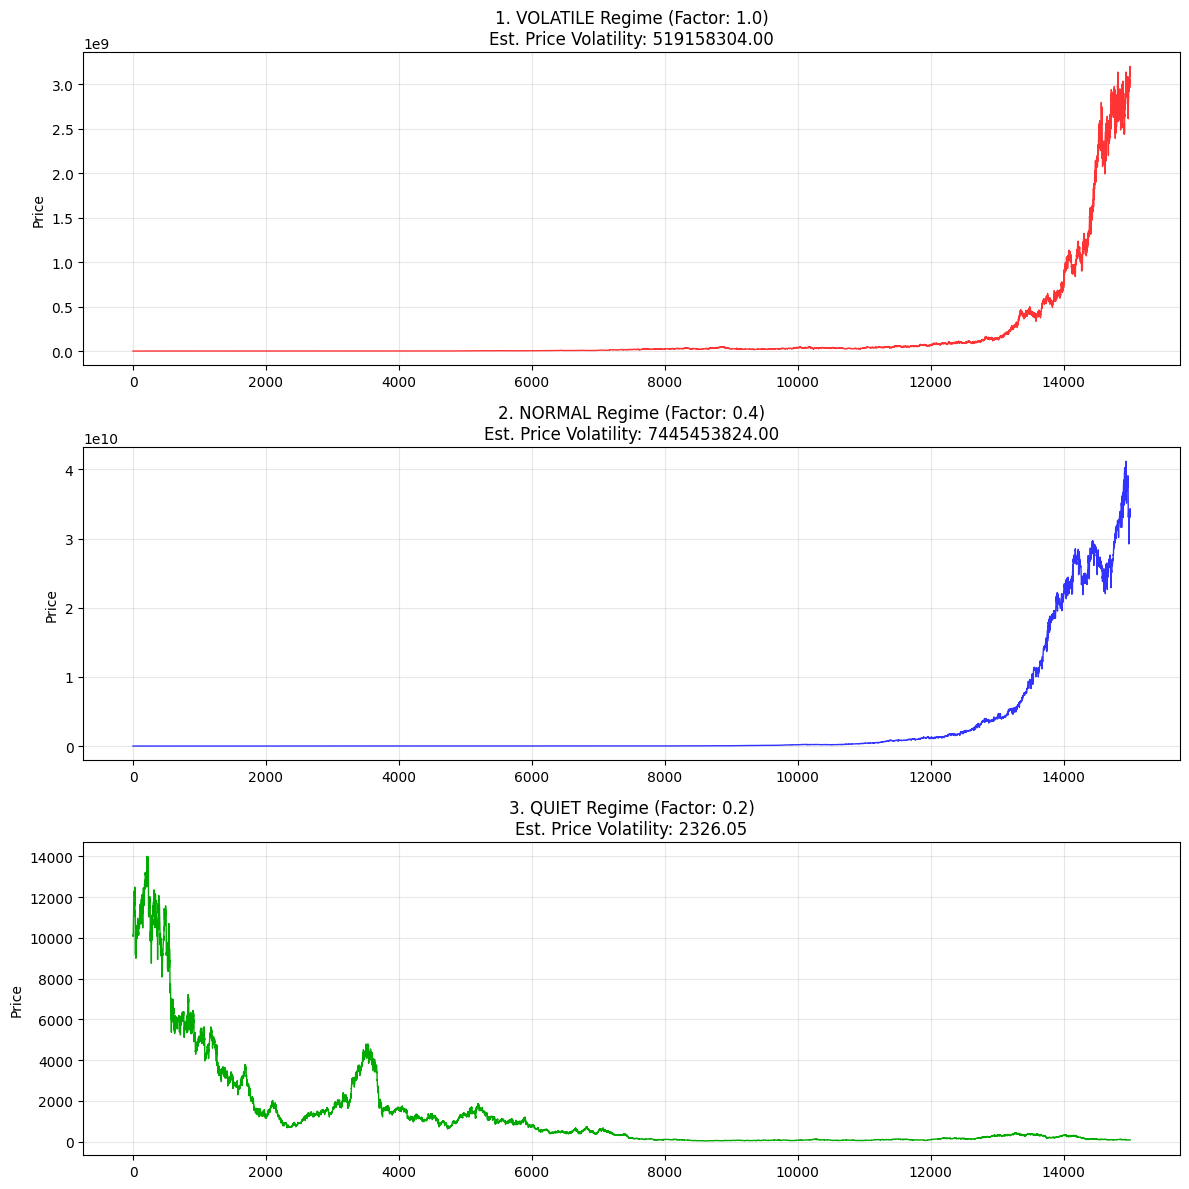

In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import joblib
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from google.colab import drive

# --- 1. SETUP ---
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# Configuration
N_SEQUENCES = 500
SEQ_LENGTH = 30
LATENT_DIM = 100

# Paths
PATH_MAP = {
    "volatile": {
        "model": "/content/drive/MyDrive/UMLFiles/Volatile/gan_models_volatile_generator_volatile_final.keras",
        "scaler": "/content/drive/MyDrive/UMLFiles/Volatile/gan_models_volatile_scaler.save"
    },
    "normal": {
        "model": "/content/drive/MyDrive/UMLFiles/Normal/gan_models_normal_generator_normal_final.keras",
        "scaler": "/content/drive/MyDrive/UMLFiles/Normal/gan_models_normal_scaler.save"
    },
    "quiet": {
        "model": "/content/drive/MyDrive/UMLFiles/Quiet/gan_models_quiet_generator_quiet_final.keras",
        "scaler": "/content/drive/MyDrive/UMLFiles/Quiet/gan_models_quiet_scaler.save"
    }
}

# --- 2. RECONSTRUCTION LOGIC ---
def get_price_series(data_array):
    prices = []
    current_price = 10000.0
    for seq in data_array:
        for step in seq:
            ret = np.clip(step[2], -0.1, 0.1)
            current_price = current_price * np.exp(ret)
            prices.append(current_price)
    return prices

# --- 3. GENERATION LOOP (Refactored) ---
# Now accepts 'volatility_scale' as an explicit argument
def generate_and_clean(regime, volatility_scale):
    print(f"⚡ Generating {regime.upper()} with factor {volatility_scale}...")

    paths = PATH_MAP[regime]
    local_mod = f"gen_{regime}.h5"
    local_scl = f"scl_{regime}.save"

    try:
        shutil.copy(paths['model'], local_mod)
        shutil.copy(paths['scaler'], local_scl)
        model = load_model(local_mod, compile=False)
        scaler = joblib.load(local_scl)
    except Exception as e:
        print(f"❌ Error loading {regime}: {e}")
        return None

    # Generate Raw
    noise = tf.random.normal((N_SEQUENCES, SEQ_LENGTH, LATENT_DIM))
    raw_output = model.predict(noise, verbose=0)

    # Inverse Scale
    flat = raw_output.reshape(-1, 4)
    inverse = scaler.inverse_transform(flat).reshape(N_SEQUENCES, SEQ_LENGTH, 4)

    # --- APPLY CORRECTIONS ---
    # 1. Remove Drift
    bias = np.mean(inverse[:, :, 2])
    inverse[:, :, 2] -= bias

    # 2. Apply the Function Parameter (The Scaling)
    inverse[:, :, 2] *= volatility_scale

    return get_price_series(inverse)

# --- 4. PLOTTING ---

# Define your factors here to pass into the function
CORRECTION_FACTORS = {'volatile': 1.0, 'normal': 0.4, 'quiet': 0.2}

results = {}
plt.figure(figsize=(12, 12))

# We iterate through your dictionary to create the plots
for i, (regime, factor) in enumerate(CORRECTION_FACTORS.items(), 1):

    # Pass the specific factor into the function here
    price_data = generate_and_clean(regime, volatility_scale=factor)

    if price_data:
        plt.subplot(3, 1, i)

        # Color logic
        color = '#FF3333' if regime == 'volatile' else '#3333FF' if regime == 'normal' else '#00AA00'

        plt.plot(price_data, color=color, linewidth=1)
        std_val = np.std(price_data)

        plt.title(f"{i}. {regime.upper()} Regime (Factor: {factor})\nEst. Price Volatility: {std_val:.2f}")
        plt.ylabel("Price")
        plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


⚡ Input Factor: 0.15 -> Selected Model: QUIET


/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.0.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


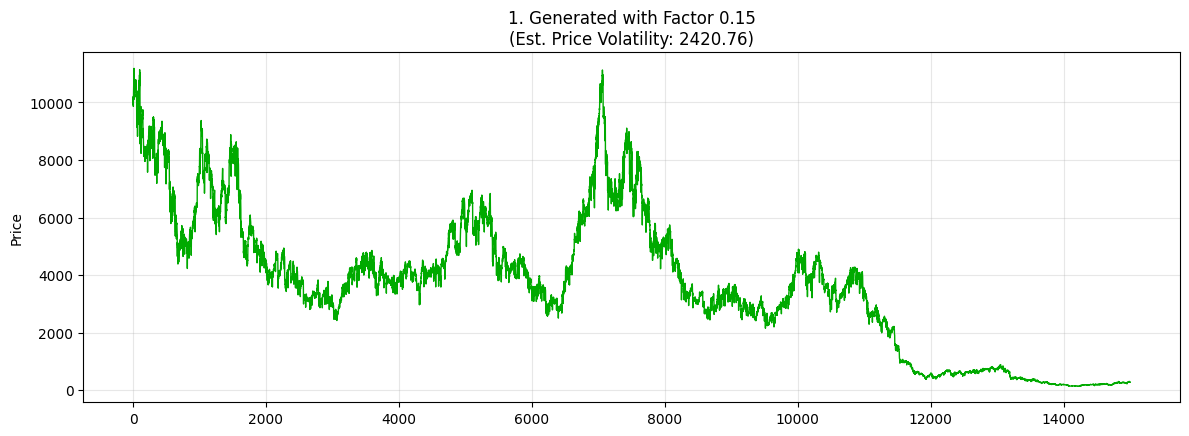

In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import joblib
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from google.colab import drive

# --- 1. SETUP ---
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# Configuration
N_SEQUENCES = 500
SEQ_LENGTH = 30
LATENT_DIM = 100

# Paths
PATH_MAP = {
    "volatile": {
        "model": "/content/drive/MyDrive/UMLFiles/Volatile/gan_models_volatile_generator_volatile_final.keras",
        "scaler": "/content/drive/MyDrive/UMLFiles/Volatile/gan_models_volatile_scaler.save"
    },
    "normal": {
        "model": "/content/drive/MyDrive/UMLFiles/Normal/gan_models_normal_generator_normal_final.keras",
        "scaler": "/content/drive/MyDrive/UMLFiles/Normal/gan_models_normal_scaler.save"
    },
    "quiet": {
        "model": "/content/drive/MyDrive/UMLFiles/Quiet/gan_models_quiet_generator_quiet_final.keras",
        "scaler": "/content/drive/MyDrive/UMLFiles/Quiet/gan_models_quiet_scaler.save"
    }
}

# --- 2. RECONSTRUCTION LOGIC ---
def get_price_series(data_array):
    prices = []
    current_price = 10000.0
    for seq in data_array:
        for step in seq:
            ret = np.clip(step[2], -0.1, 0.1)
            current_price = current_price * np.exp(ret)
            prices.append(current_price)
    return prices

# --- 3. GENERATION LOGIC (Automatic Selection) ---
def generate_from_volatility(volatility_factor):

    # A. Determine Regime based on your logic
    if volatility_factor < 0.2:
        regime = "quiet"
    elif 0.2 <= volatility_factor <= 0.6:
        regime = "normal"
    else:
        regime = "volatile"

    print(f"⚡ Input Factor: {volatility_factor} -> Selected Model: {regime.upper()}")

    # B. Load Files
    paths = PATH_MAP[regime]
    local_mod = f"gen_{regime}.h5"
    local_scl = f"scl_{regime}.save"

    try:
        shutil.copy(paths['model'], local_mod)
        shutil.copy(paths['scaler'], local_scl)
        model = load_model(local_mod, compile=False)
        scaler = joblib.load(local_scl)
    except Exception as e:
        print(f"❌ Error loading {regime}: {e}")
        return None

    # C. Generate Raw
    noise = tf.random.normal((N_SEQUENCES, SEQ_LENGTH, LATENT_DIM))
    raw_output = model.predict(noise, verbose=0)

    # D. Inverse Scale
    flat = raw_output.reshape(-1, 4)
    inverse = scaler.inverse_transform(flat).reshape(N_SEQUENCES, SEQ_LENGTH, 4)

    # E. --- APPLY CORRECTIONS ---
    # 1. Remove Drift
    bias = np.mean(inverse[:, :, 2])
    inverse[:, :, 2] -= bias

    # 2. Apply Your Input Number as the Scaling Factor
    inverse[:, :, 2] *= volatility_factor

    return get_price_series(inverse)


# --- 4. PLOTTING EXAMPLE ---
# You can now put any numbers you want in this list:
test_volatilities = [0.15]

plt.figure(figsize=(12, 12))

for i, val in enumerate(test_volatilities, 1):
    price_data = generate_from_volatility(val)

    if price_data:
        plt.subplot(3, 1, i)

        # Color logic for visualization
        if val < 0.2: color = '#00AA00'      # Green (Quiet)
        elif val <= 0.6: color = '#3333FF'   # Blue (Normal)
        else: color = '#FF3333'              # Red (Volatile)

        plt.plot(price_data, color=color, linewidth=1)
        std_val = np.std(price_data)

        plt.title(f"{i}. Generated with Factor {val}\n(Est. Price Volatility: {std_val:.2f})")
        plt.ylabel("Price")
        plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
## kks test

⚡ Factor: 0.15 -> Model: QUIET


/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.0.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


⚡ Factor: 0.5 -> Model: NORMAL


/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.0.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


⚡ Factor: 1.0 -> Model: VOLATILE


/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.0.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


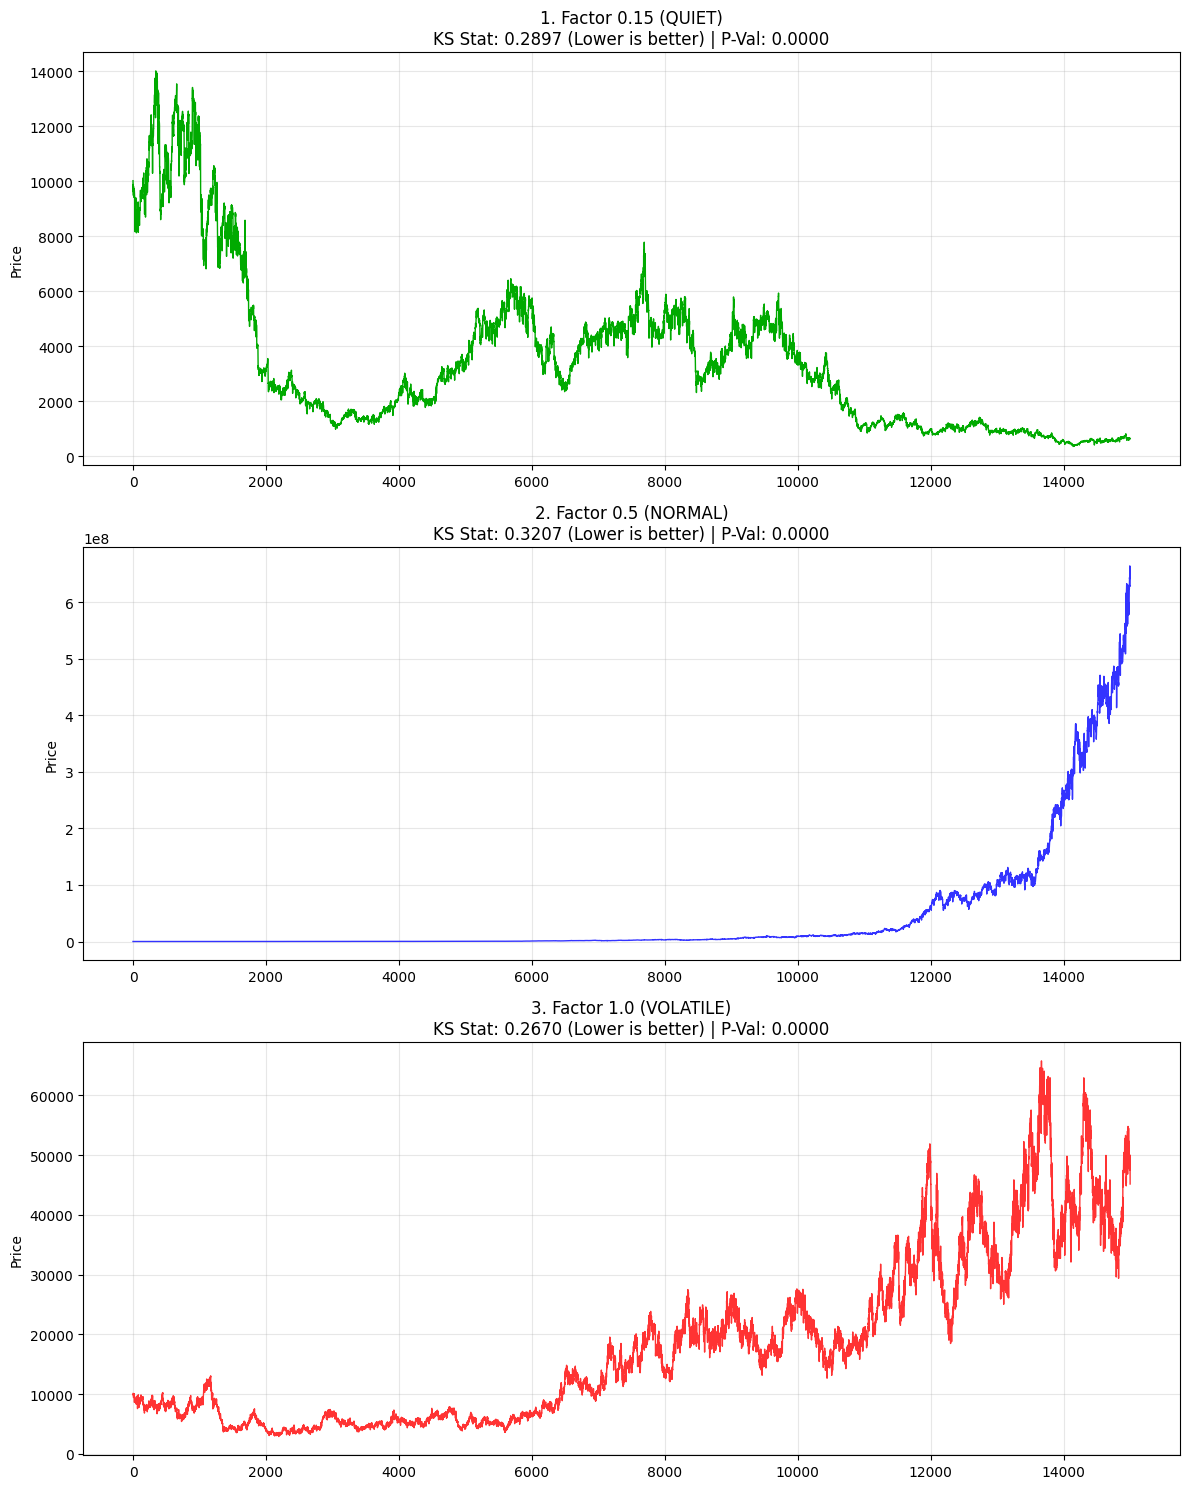

In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import joblib
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from scipy.stats import ks_2samp # <--- NEW IMPORT
from google.colab import drive

# --- 1. SETUP ---
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# Configuration
N_SEQUENCES = 500
SEQ_LENGTH = 30 # Corrected from 7 to 30
LATENT_DIM = 100

# Paths to Models
PATH_MAP = {
    "volatile": {
        "model": "/content/drive/MyDrive/UMLFiles/Volatile/gan_models_volatile_generator_volatile_final.keras",
        "scaler": "/content/drive/MyDrive/UMLFiles/Volatile/gan_models_volatile_scaler.save"
    },
    "normal": {
        "model": "/content/drive/MyDrive/UMLFiles/Normal/gan_models_normal_generator_normal_final.keras",
        "scaler": "/content/drive/MyDrive/UMLFiles/Normal/gan_models_normal_scaler.save"
    },
    "quiet": {
        "model": "/content/drive/MyDrive/UMLFiles/Quiet/gan_models_quiet_generator_quiet_final.keras",
        "scaler": "/content/drive/MyDrive/UMLFiles/Quiet/gan_models_quiet_scaler.save"
    }
}

# ❌ UPDATE THESE PATHS TO YOUR REAL TRAINING DATA CSVs
REAL_DATA_PATHS = {
    "volatile": "/content/drive/MyDrive/UMLFiles/Volatile/regime_volatile.csv",
    "normal":   "/content/drive/MyDrive/UMLFiles/Normal/regime_normal.csv",
    "quiet":    "/content/drive/MyDrive/UMLFiles/Quiet/regime_quiet.csv"
}

# --- 2. HELPER: LOAD REAL DATA ---
def get_real_returns(regime_name, limit=5000):
    """Loads a sample of real log-returns for comparison."""
    path = REAL_DATA_PATHS.get(regime_name)
    if not os.path.exists(path):
        print(f"⚠️ Real data not found at {path}. Returning random noise for testing.")
        return np.random.normal(0, 0.01, limit) # Fallback

    try:
        # Assuming headerless CSV based on your previous code
        df = pd.read_csv(path, header=None, nrows=limit)

        # Determine column index for price (usually 6 based on Tardis schema, or check your specific CSV)
        # If your CSV is just the processed 4 columns [dt, type, ret, amt], use index 2
        # Let's assume it is the PROCESSED data (4 cols). If it's RAW Tardis, we need to calculate returns.

        # Scenario A: You saved the processed features (best case)
        if df.shape[1] == 4:
            return df.iloc[:, 2].values # Return column

        # Scenario B: Raw Tardis Data (needs processing)
        else:
            # Assuming Price is column 6
            prices = df.iloc[:, 6]
            prices = pd.to_numeric(prices, errors='coerce').ffill()
            returns = np.log(prices).diff().dropna().values
            return returns

    except Exception as e:
        print(f"⚠️ Error reading real data: {e}")
        return np.random.normal(0, 0.01, limit)

# --- 3. RECONSTRUCTION LOGIC ---
def get_price_series(returns_array):
    prices = []
    current_price = 10000.0
    for r in returns_array:
        # returns_array is flat here
        ret = np.clip(r, -0.1, 0.1)
        current_price = current_price * np.exp(ret)
        prices.append(current_price)
    return prices

# --- 4. GENERATION LOGIC ---
def generate_from_volatility(volatility_factor):

    # A. Determine Regime
    if volatility_factor < 0.2:
        regime = "quiet"
    elif 0.2 <= volatility_factor <= 0.6:
        regime = "normal"
    else:
        regime = "volatile"

    print(f"⚡ Factor: {volatility_factor} -> Model: {regime.upper()}")

    # B. Load Model/Scaler
    paths = PATH_MAP[regime]
    local_mod = f"gen_{regime}.h5"
    local_scl = f"scl_{regime}.save"

    try:
        if not os.path.exists(local_mod): shutil.copy(paths['model'], local_mod)
        if not os.path.exists(local_scl): shutil.copy(paths['scaler'], local_scl)
        model = load_model(local_mod, compile=False)
        scaler = joblib.load(local_scl)
    except Exception as e:
        print(f"❌ Error loading {regime}: {e}")
        return None, None, None

    # C. Generate
    noise = tf.random.normal((N_SEQUENCES, SEQ_LENGTH, LATENT_DIM))
    raw_output = model.predict(noise, verbose=0)

    # D. Inverse Scale
    flat = raw_output.reshape(-1, 4)
    inverse = scaler.inverse_transform(flat).reshape(N_SEQUENCES, SEQ_LENGTH, 4)

    # E. Apply Corrections
    # 1. Remove Drift
    bias = np.mean(inverse[:, :, 2])
    inverse[:, :, 2] -= bias

    # 2. Apply Input Factor
    inverse[:, :, 2] *= volatility_factor

    # Get the specific returns column for KS test (Flatten it)
    synthetic_returns = inverse[:, :, 2].flatten()

    # Get Prices
    price_series = get_price_series(synthetic_returns)

    return price_series, synthetic_returns, regime


# --- 5. PLOTTING & KS TEST ---
test_volatilities = [0.15, 0.5, 1.0]

plt.figure(figsize=(12, 15))

for i, val in enumerate(test_volatilities, 1):
    # 1. Generate Data
    price_data, syn_rets, regime_name = generate_from_volatility(val)

    if price_data:
        # 2. Load Real Data for Comparison
        real_rets = get_real_returns(regime_name)

        # 3. Calculate KS Test
        # We compare the generated returns vs real returns
        ks_stat, p_value = ks_2samp(real_rets, syn_rets)

        # 4. Plot
        plt.subplot(3, 1, i)

        if val < 0.2: color = '#00AA00'
        elif val <= 0.6: color = '#3333FF'
        else: color = '#FF3333'

        plt.plot(price_data, color=color, linewidth=1)

        # Format Title with KS Score
        title_str = (f"{i}. Factor {val} ({regime_name.upper()})\n"
                     f"KS Stat: {ks_stat:.4f} (Lower is better) | P-Val: {p_value:.4f}")

        plt.title(title_str)
        plt.ylabel("Price")
        plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

⚡ Factor: 0.15 -> Model: QUIET


/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.0.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


⚡ Factor: 0.5 -> Model: NORMAL


/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.0.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


⚡ Factor: 1.0 -> Model: VOLATILE


/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.0.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


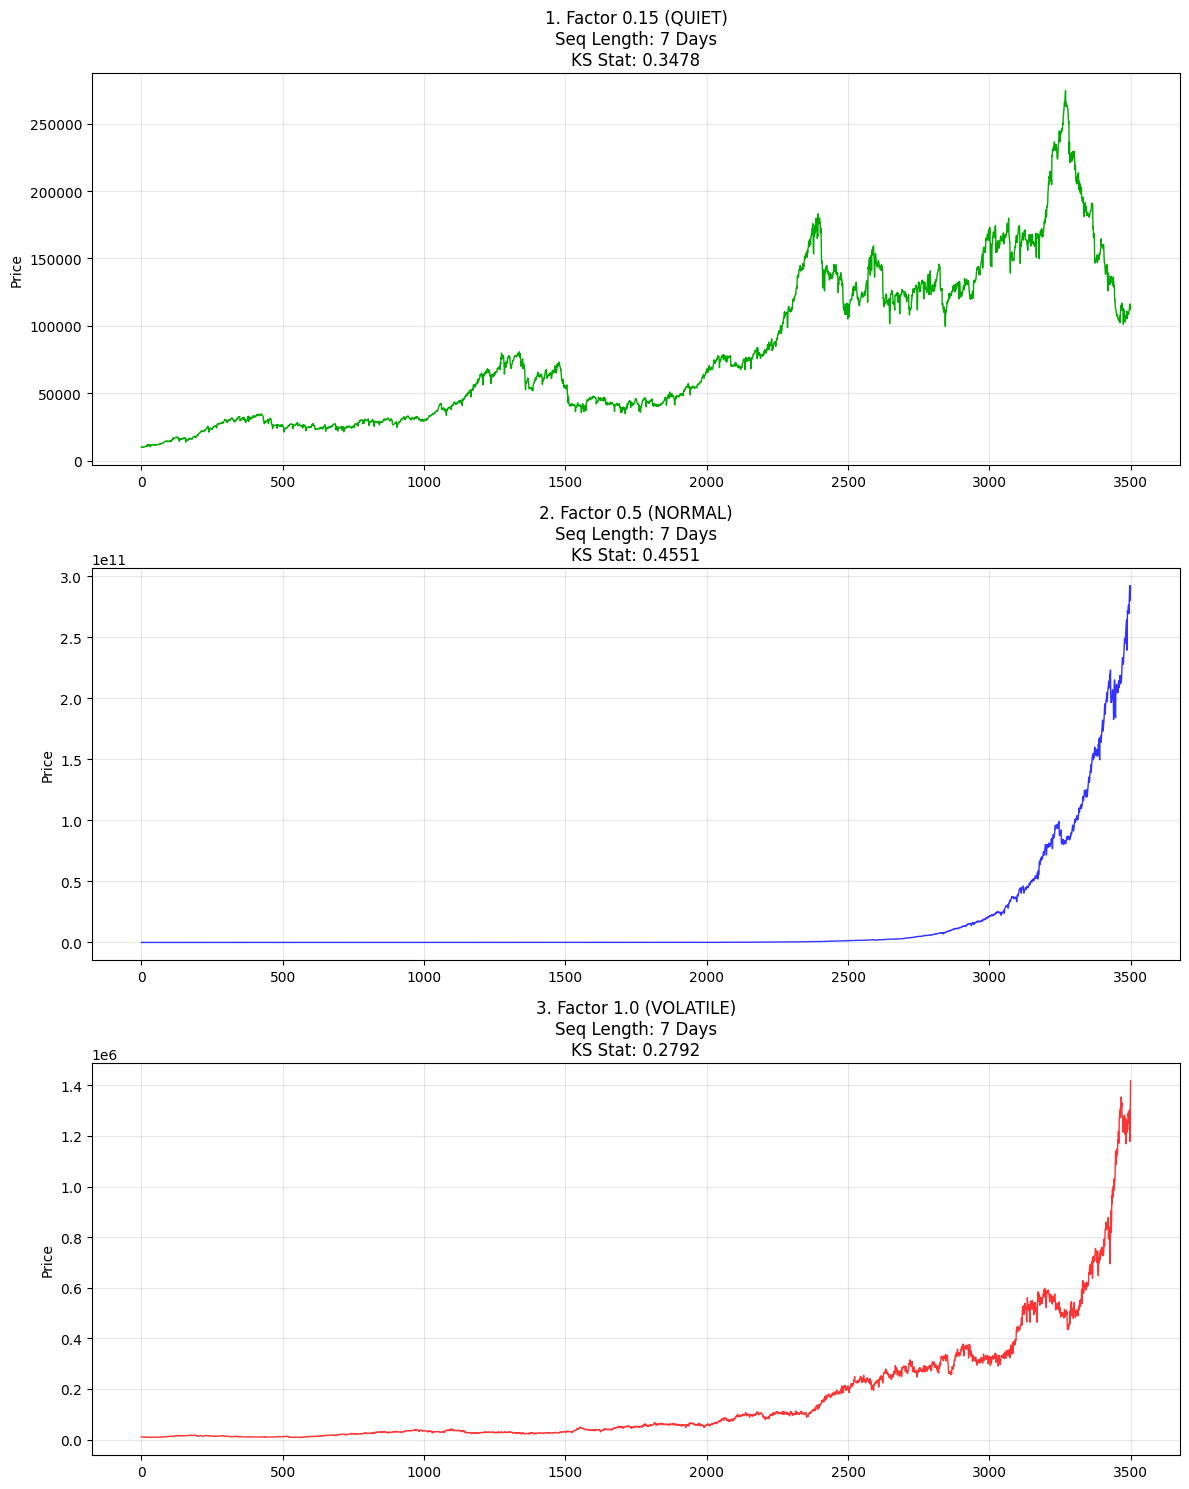

In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import joblib
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from scipy.stats import ks_2samp
from google.colab import drive

# --- 1. SETUP ---
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# Configuration
N_SEQUENCES = 500
LATENT_DIM = 100

# ---------------------------------------------------------
# ✂️ THE FIX: Separate what the model needs vs what you want
# ---------------------------------------------------------
TRAINED_SEQ_LENGTH = 30  # "The Cookie Cutter" (Fixed size of the model)
DESIRED_SEQ_LENGTH = 7   # "The Cookie" (The size you actually want)
# ---------------------------------------------------------

PATH_MAP = {
    "volatile": {
        "model": "/content/drive/MyDrive/UMLFiles/Volatile/gan_models_volatile_generator_volatile_final.keras",
        "scaler": "/content/drive/MyDrive/UMLFiles/Volatile/gan_models_volatile_scaler.save"
    },
    "normal": {
        "model": "/content/drive/MyDrive/UMLFiles/Normal/gan_models_normal_generator_normal_final.keras",
        "scaler": "/content/drive/MyDrive/UMLFiles/Normal/gan_models_normal_scaler.save"
    },
    "quiet": {
        "model": "/content/drive/MyDrive/UMLFiles/Quiet/gan_models_quiet_generator_quiet_final.keras",
        "scaler": "/content/drive/MyDrive/UMLFiles/Quiet/gan_models_quiet_scaler.save"
    }
}

REAL_DATA_PATHS = {
    "volatile": "/content/drive/MyDrive/UMLFiles/Volatile/regime_volatile.csv",
    "normal":   "/content/drive/MyDrive/UMLFiles/Normal/regime_normal.csv",
    "quiet":    "/content/drive/MyDrive/UMLFiles/Quiet/regime_quiet.csv"
}

# --- 2. HELPER: LOAD REAL DATA ---
def get_real_returns(regime_name, limit=5000):
    """Loads a sample of real log-returns for comparison."""
    path = REAL_DATA_PATHS.get(regime_name)
    if not os.path.exists(path):
        return np.random.normal(0, 0.01, limit)

    try:
        df = pd.read_csv(path, header=None, nrows=limit)
        # Assuming processed data (4 cols) or raw data. Adjust as needed.
        if df.shape[1] == 4:
            return df.iloc[:, 2].values
        else:
            # Fallback for raw tardis data
            prices = df.iloc[:, 6]
            prices = pd.to_numeric(prices, errors='coerce').ffill()
            returns = np.log(prices).diff().dropna().values
            return returns
    except Exception as e:
        print(f"⚠️ Error reading real data: {e}")
        return np.random.normal(0, 0.01, limit)

# --- 3. RECONSTRUCTION LOGIC ---
def get_price_series(returns_array):
    prices = []
    current_price = 10000.0
    for r in returns_array:
        ret = np.clip(r, -0.1, 0.1)
        current_price = current_price * np.exp(ret)
        prices.append(current_price)
    return prices

# --- 4. GENERATION LOGIC ---
def generate_from_volatility(volatility_factor):

    # A. Determine Regime
    if volatility_factor < 0.2:
        regime = "quiet"
    elif 0.2 <= volatility_factor <= 0.6:
        regime = "normal"
    else:
        regime = "volatile"

    print(f"⚡ Factor: {volatility_factor} -> Model: {regime.upper()}")

    # B. Load Model/Scaler
    paths = PATH_MAP[regime]
    local_mod = f"gen_{regime}.h5"
    local_scl = f"scl_{regime}.save"

    try:
        if not os.path.exists(local_mod): shutil.copy(paths['model'], local_mod)
        if not os.path.exists(local_scl): shutil.copy(paths['scaler'], local_scl)
        model = load_model(local_mod, compile=False)
        scaler = joblib.load(local_scl)
    except Exception as e:
        print(f"❌ Error loading {regime}: {e}")
        return None, None, None

    # C. Generate Full Sequence (30 Days)
    # We MUST input noise for 30 days because the model is built that way
    noise = tf.random.normal((N_SEQUENCES, TRAINED_SEQ_LENGTH, LATENT_DIM))
    raw_output = model.predict(noise, verbose=0) # Output shape: (500, 30, 4)

    # D. Inverse Scale Full Sequence
    # Flatten to fit scaler: (15000, 4)
    flat = raw_output.reshape(-1, 4)
    # Scale back to real numbers
    inverse_full = scaler.inverse_transform(flat).reshape(N_SEQUENCES, TRAINED_SEQ_LENGTH, 4)

    # ✂️ E. CUT TO DESIRED LENGTH (7 Days)
    # We take all sequences, first 7 time steps, all features
    inverse_sliced = inverse_full[:, :DESIRED_SEQ_LENGTH, :]

    # F. Apply Corrections to the SLICED data
    # 1. Remove Drift
    bias = np.mean(inverse_sliced[:, :, 2])
    inverse_sliced[:, :, 2] -= bias

    # 2. Apply Input Factor
    inverse_sliced[:, :, 2] *= volatility_factor

    # Get the specific returns column (Flatten for KS test)
    synthetic_returns = inverse_sliced[:, :, 2].flatten()

    # Get Prices
    price_series = get_price_series(synthetic_returns)

    return price_series, synthetic_returns, regime


# --- 5. PLOTTING & KS TEST ---
test_volatilities = [0.15, 0.5, 1.0]

plt.figure(figsize=(12, 15))

for i, val in enumerate(test_volatilities, 1):
    # 1. Generate (returns 7 days of data now)
    price_data, syn_rets, regime_name = generate_from_volatility(val)

    if price_data:
        # 2. Load Real Data
        real_rets = get_real_returns(regime_name)

        # 3. KS Test
        ks_stat, p_value = ks_2samp(real_rets, syn_rets)

        # 4. Plot
        plt.subplot(3, 1, i)

        if val < 0.2: color = '#00AA00'
        elif val <= 0.6: color = '#3333FF'
        else: color = '#FF3333'

        plt.plot(price_data, color=color, linewidth=1)

        title_str = (f"{i}. Factor {val} ({regime_name.upper()})\n"
                     f"Seq Length: {DESIRED_SEQ_LENGTH} Days\n"
                     f"KS Stat: {ks_stat:.4f}")

        plt.title(title_str)
        plt.ylabel("Price")
        plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

--- ANALYZING REGIME: VOLATILE ---
Detected Raw Data - Calculating Returns...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.0.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(



📊 STATISTICS REPORT:
Metric     | REAL Data       | FAKE Data      
---------------------------------------------
Mean       | 0.000000        | 0.008917       
Std Dev    | 0.439693        | 0.296067       
Min        | -1.930131       | -1.440855      
Max        | 1.858375        | 1.442671       

🧪 KS Test Result: P-Value = 0.0000000000


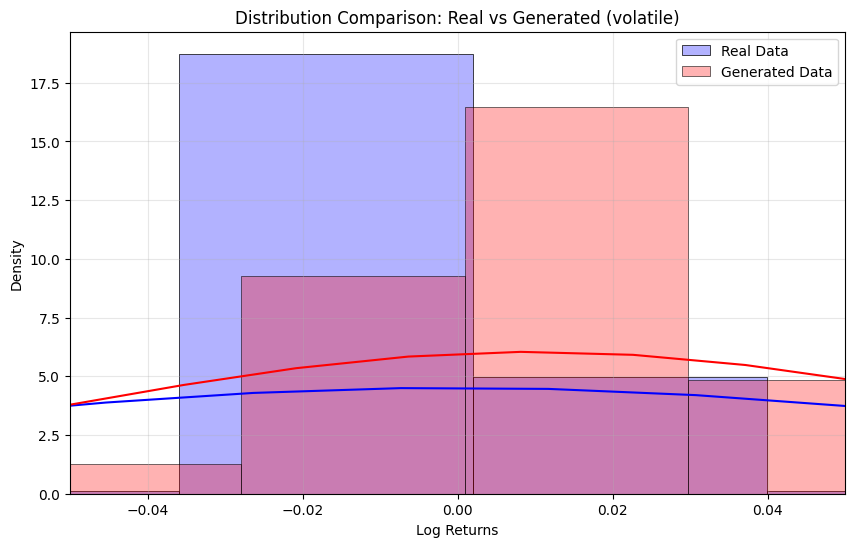

In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from scipy.stats import ks_2samp
from google.colab import drive

# --- 1. SETUP ---
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# Configuration
N_SEQUENCES = 500
TRAINED_SEQ_LENGTH = 30 # Fixed to Model
DESIRED_SEQ_LENGTH = 7  # What you want
LATENT_DIM = 100

# Paths
PATH_MAP = {
    "volatile": {
        "model": "/content/drive/MyDrive/UMLFiles/Volatile/gan_models_volatile_generator_volatile_final.keras",
        "scaler": "/content/drive/MyDrive/UMLFiles/Volatile/gan_models_volatile_scaler.save"
    },
    "normal": {
        "model": "/content/drive/MyDrive/UMLFiles/Normal/gan_models_normal_generator_normal_final.keras",
        "scaler": "/content/drive/MyDrive/UMLFiles/Normal/gan_models_normal_scaler.save"
    },
    "quiet": {
        "model": "/content/drive/MyDrive/UMLFiles/Quiet/gan_models_quiet_generator_quiet_final.keras",
        "scaler": "/content/drive/MyDrive/UMLFiles/Quiet/gan_models_quiet_scaler.save"
    }
}

REAL_DATA_PATHS = {
    "volatile": "/content/drive/MyDrive/UMLFiles/Volatile/regime_volatile.csv",
    "normal":   "/content/drive/MyDrive/UMLFiles/Normal/regime_normal.csv",
    "quiet":    "/content/drive/MyDrive/UMLFiles/Quiet/regime_quiet.csv"
}

# --- 2. LOAD REAL DATA ---
def get_real_returns(regime_name, limit=5000):
    path = REAL_DATA_PATHS.get(regime_name)
    if not os.path.exists(path):
        print(f"⚠️ File not found: {path}")
        return np.array([])

    try:
        # Attempt to read CSV
        df = pd.read_csv(path, header=None, nrows=limit)

        # LOGIC: Check if this is Processed (4 cols) or Raw (Tardis)
        if df.shape[1] == 4:
            # Assuming Col 2 is returns
            data = df.iloc[:, 2].values
        else:
            # Assuming Col 6 is Price
            print("Detected Raw Data - Calculating Returns...")
            prices = pd.to_numeric(df.iloc[:, 6], errors='coerce').ffill()
            data = np.log(prices).diff().dropna().values

        # CLEANUP: Remove infinite or NaN values
        data = data[~np.isnan(data)]
        data = data[~np.isinf(data)]

        return data

    except Exception as e:
        print(f"⚠️ Error: {e}")
        return np.array([])

# --- 3. GENERATE SYNTHETIC DATA ---
def generate_sample(regime, volatility_factor=1.0):
    """Generates a sample without the loop, specifically for comparison."""
    paths = PATH_MAP[regime]
    local_mod = f"gen_{regime}.h5"
    local_scl = f"scl_{regime}.save"

    # Load
    if not os.path.exists(local_mod): shutil.copy(paths['model'], local_mod)
    if not os.path.exists(local_scl): shutil.copy(paths['scaler'], local_scl)
    model = load_model(local_mod, compile=False)
    scaler = joblib.load(local_scl)

    # Generate (30 steps)
    noise = tf.random.normal((N_SEQUENCES, TRAINED_SEQ_LENGTH, LATENT_DIM))
    raw = model.predict(noise, verbose=0)

    # Inverse Scale
    flat = raw.reshape(-1, 4)
    inverse = scaler.inverse_transform(flat).reshape(N_SEQUENCES, TRAINED_SEQ_LENGTH, 4)

    # Slice to 7 steps
    inverse_sliced = inverse[:, :DESIRED_SEQ_LENGTH, :]

    # Extract Returns (Column 2)
    # Note: We do NOT apply manual volatility factor here to see raw GAN performance first
    # unless you explicitly want to test the modifier.
    syn_rets = inverse_sliced[:, :, 2].flatten()

    # Apply modifier if needed
    syn_rets = syn_rets * volatility_factor

    return syn_rets

# --- 4. COMPARE AND PLOT ---
def run_comparison(target_regime="volatile"):
    print(f"--- ANALYZING REGIME: {target_regime.upper()} ---")

    # 1. Get Data
    real_data = get_real_returns(target_regime)
    fake_data = generate_sample(target_regime, volatility_factor=0.7) # Start with 1.0

    if len(real_data) == 0:
        print("CRITICAL: Could not load real data.")
        return

    # 2. Print Stats (The "Sanity Check")
    print(f"\n📊 STATISTICS REPORT:")
    print(f"{'Metric':<10} | {'REAL Data':<15} | {'FAKE Data':<15}")
    print("-" * 45)
    print(f"{'Mean':<10} | {np.mean(real_data):<15.6f} | {np.mean(fake_data):<15.6f}")
    print(f"{'Std Dev':<10} | {np.std(real_data):<15.6f} | {np.std(fake_data):<15.6f}")
    print(f"{'Min':<10} | {np.min(real_data):<15.6f} | {np.min(fake_data):<15.6f}")
    print(f"{'Max':<10} | {np.max(real_data):<15.6f} | {np.max(fake_data):<15.6f}")

    # 3. KS Test
    ks_stat, p_val = ks_2samp(real_data, fake_data)
    print(f"\n🧪 KS Test Result: P-Value = {p_val:.10f}")

    # 4. Plot Distributions
    plt.figure(figsize=(10, 6))

    # Plot histograms with density curve (KDE)
    sns.histplot(real_data, color="blue", label='Real Data', kde=True, stat="density", alpha=0.3, bins=100)
    sns.histplot(fake_data, color="red", label='Generated Data', kde=True, stat="density", alpha=0.3, bins=100)

    plt.title(f"Distribution Comparison: Real vs Generated ({target_regime})")
    plt.xlabel("Log Returns")
    plt.ylabel("Density")
    plt.legend()
    plt.xlim(-0.05, 0.05) # Zoom in to see the center (Adjust if crypto is crazy volatile)
    plt.grid(True, alpha=0.3)
    plt.show()

# --- RUN IT ---
# Change this to "normal", "quiet", or "volatile"
run_comparison("volatile")